In [1]:
pip install yfinance #install yfinance

  Obtaining dependency information for yfinance from https://files.pythonhosted.org/packages/e6/b3/388ab967a387cc92926f70e97688dd9a7189b29a0773db815ffc5289e2b5/yfinance-0.2.31-py2.py3-none-any.whl.metadata
     ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
     - -------------------------------------- 0.1/2.9 MB 2.8 MB/s eta 0:00:01
     --- ------------------------------------ 0.3/2.9 MB 5.2 MB/s eta 0:00:01
     ---- ----------------------------------- 0.3/2.9 MB 2.5 MB/s eta 0:00:02
     ------ --------------------------------- 0.5/2.9 MB 3.2 MB/s eta 0:00:01
     --------- ------------------------------ 0.7/2.9 MB 3.7 MB/s eta 0:00:01
     ------------ --------------------------- 0.9/2.9 MB 3.9 MB/s eta 0:00:01
     --------------- ------------------------ 1.2/2.9 MB 4.1 MB/s eta 0:00:01
     ----------------- ---------------------- 1.3/2.9 MB 4.0 MB/s eta 0:00:01
     --------------------- ------------------ 1.6/2.9 MB 4.1 MB/s eta 0:00:01
     ----------------

In [5]:
#import libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as md
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf        #for autocorrelation functions
from statsmodels.graphics.tsaplots import plot_acf
import scipy.stats as stats                      #for kurtosis & skewness functions

from statsmodels.stats.diagnostic import lilliefors

import scipy.signal as ss
from scipy.stats import gaussian_kde, norm, iqr, skew, kurtosis, jarque_bera, kstest, anderson
import pylab

#Download Roche Holding historical data - Ticker: ROG.SW
roche = yf.download("ROG.SW", start="1996-01-01", end="2022-12-31")
#Extract prices & returns
Pt_d = roche['Adj Close']               #modify data frame for adjusted prices
pt_d = np.log(Pt_d)                     #log prices
#weekly, monthly & yearly prices
pt_w = pt_d.resample('W').last()
pt_m = pt_d.resample('M').last()
pt_y = pt_d.resample('Y').last()
#calculate returns & drop 1st observation
rt_d = pt_d.diff().dropna()
rt_w = pt_w.diff().dropna()
rt_m = pt_m.diff().dropna()
rt_y = pt_y.diff().dropna()
roche.to_excel("Data_Yf.xlsx")
roche

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-01-01,84.836403,84.836403,84.836403,84.836403,44.102867,0
1996-01-02,84.836403,84.836403,84.836403,84.836403,44.102867,0
1996-01-03,84.836403,84.836403,84.836403,84.836403,44.102867,0
1996-01-04,89.341904,89.533600,89.102203,89.341904,46.445080,200110000
1996-01-05,89.341904,89.341904,89.341904,89.341904,46.445080,0
...,...,...,...,...,...,...
2022-12-23,295.250000,298.200012,294.049988,295.200012,284.631317,561755
2022-12-27,295.750000,296.799988,294.049988,294.100006,283.570709,426231
2022-12-28,293.500000,294.649994,291.750000,292.549988,282.076172,680079


In [40]:
#function for plotting prices time series
def timeseries_prices(prices,log_prices):
    fig, ax = plt.subplots(1, 2, figsize=(25,10))
    ax[0].plot(prices.index, prices, color='cyan')
    ax[0].set_title('Price: $P_t$', fontsize=24)
    ax[0].grid(True)
    ax[0].set_facecolor('black')                             #change background color
    ax[0].tick_params(axis='x', which='major', labelsize=16) #change axis font size
    ax[0].tick_params(axis='y', which='major', labelsize=16)
    ax[1].plot(log_prices.index, log_prices, color='red')
    ax[1].set_title('Log Price: $p_t$',fontsize=26)
    ax[1].grid(True)
    ax[1].set_facecolor('black')
    ax[1].tick_params(axis='x', which='major', labelsize=16)
    ax[1].tick_params(axis='y', which='major', labelsize=16)
    plt.tight_layout()
    plt.show()

In [41]:
#function for scatter plot
def scatter_prices(data,xlabel,ylabel,title):
    fig , ax = plt.subplots()
    ax.scatter(data.shift(),data, color='cyan')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.plot([min(data),max(data)], [min(data),max(data)], linestyle='dashed', color='red')
    ax.grid(True)
    ax.tick_params(axis='x', which='major', labelsize=10)
    ax.tick_params(axis='y', which='major', labelsize=10)
    ax.set_facecolor('black')
    plt.show()

In [18]:
#autocorrelation function for prices
def autocorr_prices(daily_prices, monthly_prices):
    #autocorrelation
    lags = 40
    acf_values_d = acf(daily_prices, nlags=lags)
    acf_values_m = acf(monthly_prices, nlags=lags)

    #Bartlett intervals
    Bart_Int_d = 1.96 / np.sqrt(len(daily_prices))
    Bart_Int_m = 1.96 / np.sqrt(len(monthly_prices))

    #autocorrelation plot with Bartlett intervals : daily
    fig, ax = plt.subplots(1,2,figsize=(25, 10))
    ax[0].stem(np.arange(1, lags + 1), acf_values_d[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
    ax[0].axhline(y=0, color='black', linestyle='--')
    ax[0].axhline(y=Bart_Int_d, color='blue', linestyle='--')
    ax[0].axhline(y=-Bart_Int_d, color='blue', linestyle='--')
    ax[0].set_title('Autocorrelations of daily Prices', fontsize=24)
    ax[0].set_xlabel('Lag', fontsize = 20)
    ax[0].set_ylabel('ACF', fontsize = 20)
    ax[0].tick_params(axis='y', which='major', labelsize=16)
    ax[0].tick_params(axis='x', which='major', labelsize=16)
    ax[0].set_facecolor('lightgray')
    ax[0].grid(True)
    #monthly
    ax[1].stem(np.arange(1, lags + 1), acf_values_m[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
    ax[1].axhline(y=0, color='black', linestyle='--')
    ax[1].axhline(y=Bart_Int_m, color='blue', linestyle='--')
    ax[1].axhline(y=-Bart_Int_m, color='blue', linestyle='--')
    ax[1].set_title('Autocorrelations of monthly Prices', fontsize=24)
    ax[1].set_xlabel('Lag', fontsize = 20)
    ax[1].set_ylabel('ACF', fontsize = 20)
    ax[1].tick_params(axis='y', which='major', labelsize=16)
    ax[1].tick_params(axis='x', which='major', labelsize=16)
    ax[1].set_facecolor('lightgray')
    ax[1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print("Daily:", "+/-", round(Bart_Int_d,3))
    print("Monthly:", "+/-", round(Bart_Int_m,3))

In [15]:
#autocorrelation function for returns with argument for Squared / Absolute
def autocorr_ret(daily_ret, weekly_ret, monthly_ret, lags, form):
    if form == 1:                           #check if form is squred log returns
        acf_values_d = acf(daily_ret**2, nlags=lags)
        acf_values_w = acf(weekly_ret**2, nlags=lags)
        acf_values_m = acf(monthly_ret**2, nlags=lags)
    elif form == 2:                         #check if form is absolute log returns
        acf_values_d = acf(abs(daily_ret), nlags=lags)
        acf_values_w = acf(abs(weekly_ret), nlags=lags)
        acf_values_m = acf(abs(monthly_ret), nlags=lags)
    else:                                   #default log returns
        acf_values_d = acf(daily_ret, nlags=lags)
        acf_values_w = acf(weekly_ret, nlags=lags)
        acf_values_m = acf(monthly_ret, nlags=lags)
    

    #Bartlett intervals
    Bart_Int_d = 1.96 / np.sqrt(len(daily_ret))
    Bart_Int_w = 1.96 / np.sqrt(len(weekly_ret))
    Bart_Int_m = 1.96 / np.sqrt(len(monthly_ret))

    #autocorrelation plot with Bartlett intervals : daily
    fig, ax = plt.subplots(1,3,figsize=(25, 8))
    ax[0].stem(np.arange(1, lags + 1), acf_values_d[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
    ax[0].axhline(y=0, color='black', linestyle='--')
    ax[0].axhline(y=Bart_Int_d, color='blue', linestyle='--')
    ax[0].axhline(y=-Bart_Int_d, color='blue', linestyle='--')
    ax[0].set_ylim(-0.2, 0.5)                #set y axis scale limit
    #customize title according to form input
    if form == 1:
        ax[0].set_title('Autocorrelations of daily squared log Returns', fontsize=24)
    elif form == 2:
        ax[0].set_title('Autocorrelations of daily absolute log Returns', fontsize=24)
    else:
        ax[0].set_title('Autocorrelations of daily log Returns', fontsize=24)
    ax[0].set_xlabel('Lag', fontsize = 20)
    ax[0].set_ylabel('ACF', fontsize = 20)
    ax[0].tick_params(axis='y', which='major', labelsize=16)
    ax[0].tick_params(axis='x', which='major', labelsize=16)
    ax[0].set_facecolor('lightgray')
    ax[0].grid(True)
    #weekly
    ax[1].stem(np.arange(1, lags + 1), acf_values_w[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
    ax[1].axhline(y=0, color='black', linestyle='--')
    ax[1].axhline(y=Bart_Int_w, color='blue', linestyle='--')
    ax[1].axhline(y=-Bart_Int_w, color='blue', linestyle='--')
    ax[1].set_ylim(-0.2, 0.5)
    if form == 1:
        ax[1].set_title('Autocorrelations of weekly squared log Returns', fontsize=24)
    elif form == 2:
        ax[1].set_title('Autocorrelations of weekly absolute log Returns', fontsize=24)
    else:
        ax[1].set_title('Autocorrelations of weekly log Returns', fontsize=24)
    ax[1].set_xlabel('Lag', fontsize = 20)
    ax[1].set_ylabel('ACF', fontsize = 20)
    ax[1].tick_params(axis='y', which='major', labelsize=16)
    ax[1].tick_params(axis='x', which='major', labelsize=16)
    ax[1].set_facecolor('lightgray')
    ax[1].grid(True)
    #monthly
    ax[2].stem(np.arange(1, lags + 1), acf_values_m[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
    ax[2].axhline(y=0, color='black', linestyle='--')
    ax[2].axhline(y=Bart_Int_m, color='blue', linestyle='--')
    ax[2].axhline(y=-Bart_Int_m, color='blue', linestyle='--')
    ax[2].set_ylim(-0.2, 0.5)
    if form == 1:
        ax[2].set_title('Autocorrelations of monthly squared log Returns', fontsize=24)
    elif form == 2:
        ax[2].set_title('Autocorrelations of monthly absolute log Returns', fontsize=24)
    else:
        ax[2].set_title('Autocorrelations of monthly log Returns', fontsize=24)
    ax[2].set_xlabel('Lag', fontsize = 20)
    ax[2].set_ylabel('ACF', fontsize = 20)
    ax[2].tick_params(axis='y', which='major', labelsize=16)
    ax[2].tick_params(axis='x', which='major', labelsize=16)
    ax[2].set_facecolor('lightgray')
    ax[2].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print("Daily:", "+/-", round(Bart_Int_d,3))
    print("Weekly:", "+/-", round(Bart_Int_w,3))
    print("Monthly:", "+/-", round(Bart_Int_m,3))

In [25]:
#function for time series log returns & squared returns
def timeseries_ret(log_return):
    fig, ax = plt.subplots(1, 2, figsize=(25, 10))
    ax[0].plot(log_return.index, log_return, color='blue')
    ax[0].set_title('Daily log-returns: $r_t$', fontsize=24)
    ax[0].set_facecolor('black')
    ax[0].tick_params(axis='x', which='major', labelsize=16)
    ax[0].tick_params(axis='y', which='major', labelsize=16)
    ax[0].grid(True)
    ax[1].plot(log_return.index, log_return**2, color='blue')
    ax[1].set_title('Squared daily log-returns: $r_t$', fontsize=24)
    ax[1].set_facecolor('black')
    ax[1].tick_params(axis='x', which='major', labelsize=16)
    ax[1].tick_params(axis='y', which='major', labelsize=16)
    ax[1].grid(True)
    plt.tight_layout()
    plt.show()

In [65]:
#function for histogram
def histogram (log_returns_daily, log_returns_monthly):
    fig, ax = plt.subplots(1, 2, figsize=(25, 10))
    
    #Plot daily of monthly log-returns
    ax[0].hist(log_returns_daily, bins=30, color='lightseagreen', edgecolor='black', density=True)
    ax[0].plot(np.linspace(log_returns_daily.min(), log_returns_daily.max(), 100),
                stats.norm.pdf(np.linspace(log_returns_daily.min(), log_returns_daily.max(), 100),
                               log_returns_daily.mean(), log_returns_daily.std()), color='yellow', linewidth=6)
    ax[0].set_title('Histogram of Daily Log-Returns',fontsize=26)
    ax[0].set_xlabel('Log-Returns',fontsize=16)
    ax[0].set_facecolor('black')
    ax[0].grid(True)
    ax[0].set_ylabel('Density',fontsize=16)
    ax[0].tick_params(axis='x',which='major',labelsize=16)
    ax[0].tick_params(axis='y',which='major',labelsize=16)
    
    
    # Plot histogram of monthly log-returns
    ax[1].hist(log_returns_monthly, bins=30, color='lightseagreen', edgecolor='black', density=True)
    ax[1].plot(np.linspace(log_returns_monthly.min(), log_returns_monthly.max(), 100),
                stats.norm.pdf(np.linspace(log_returns_monthly.min(), log_returns_monthly.max(), 100),
                               log_returns_monthly.mean(), log_returns_monthly.std()), color='yellow', linewidth=6)
    ax[1].set_title('Histogram of Monthly Log-Returns',fontsize=26)
    ax[1].set_xlabel('Log-Returns',fontsize=16)
    ax[1].set_facecolor('black')
    ax[1].grid(True)
    ax[1].set_ylabel('Density',fontsize=16)
    ax[1].tick_params(axis='x',which='major',labelsize=16)
    ax[1].tick_params(axis='y',which='major',labelsize=16)
    
    plt.tight_layout()
    plt.show()

In [64]:
#function for QQ plot
def QQ_plot(log_returns_daily, log_returns_monthly):
    fig, ax = plt.subplots(1, 2, figsize=(25, 10))
   # QQ plot of daily log-returns
    ax[0].plot = stats.probplot(log_returns_daily, dist="norm", plot=ax[0])
    ax[0].set_title('QQ Plot of Daily Log-Returns',fontsize=26)
    ax[0].set_xlabel('Normal Quantiles',fontsize=16)
    ax[0].set_ylabel('Sample Quantiles',fontsize=16)
    ax[0].set_facecolor('black')
    ax[0].get_lines()[0].set_color('lightgreen')
    ax[0].get_lines()[1].set_linewidth(4) 
    ax[0].tick_params(axis='x',which='major',labelsize=16)
    ax[0].tick_params(axis='y',which='major',labelsize=16)
    ax[0].grid(True)
    
    # QQ plot of monthly log-returns
    ax[1].plot =stats.probplot(log_returns_monthly, dist="norm", plot=ax[1])
    ax[1].set_title('QQ Plot of Monthly Log-Returns',fontsize=26)
    ax[1].set_xlabel('Normal Quantiles',fontsize=16)
    ax[1].set_ylabel('Sample Quantiles',fontsize=16)
    ax[1].set_facecolor('black')
    ax[1].get_lines()[0].set_color('lightgreen')
    ax[1].get_lines()[1].set_linewidth(4)
    ax[1].tick_params(axis='x',which='major',labelsize=16)
    ax[1].tick_params(axis='y',which='major',labelsize=16)
    ax[1].grid(True)
    
   
    plt.tight_layout()
    plt.show()

In [63]:
def QQ_plot_heavytails (log_returns_daily):
    fig, ax = plt.subplots(1, 3, figsize=(25, 10))
    #QQ plot of daily returns
    stats.probplot(log_returns_daily / np.std(log_returns_daily), dist=stats.t(df=10), plot=ax[0])
    ax[0].set_title('QQ Plot (Student-t ν=10)',fontsize=26)
    ax[0].set_xlabel('Theoretical Quantiles',fontsize=16)
    ax[0].set_ylabel('Sample Quantiles',fontsize=16)
    ax[0].set_facecolor('black')
    ax[0].get_lines()[0].set_color('lightgreen') 
    ax[0].get_lines()[1].set_linewidth(4)
    ax[0].tick_params(axis='x',which='major',labelsize=16)
    ax[0].tick_params(axis='y',which='major',labelsize=16)
    ax[0].grid(True)

    # QQ plot against Student-t distribution with ν = 5
    stats.probplot(log_returns_daily / np.std(log_returns_daily), dist=stats.t(df=5), plot=ax[1])
    ax[1].set_title('QQ Plot (Student-t ν=5)',fontsize=26)
    ax[1].set_xlabel('Theoretical Quantiles',fontsize=16)
    ax[1].set_ylabel('Sample Quantiles',fontsize=16)
    ax[1].set_facecolor('black')
    ax[1].get_lines()[0].set_color('lightgreen') 
    ax[1].get_lines()[1].set_linewidth(4)
    ax[1].tick_params(axis='x',which='major',labelsize=16)
    ax[1].tick_params(axis='y',which='major',labelsize=16)
    ax[1].grid(True)

    # QQ plot against Student-t distribution with ν = 3
    stats.probplot(log_returns_daily / np.std(log_returns_daily), dist=stats.t(df=3), plot=ax[2])
    ax[2].set_title('QQ Plot (Student-t ν=3)',fontsize=26)
    ax[2].set_xlabel('Theoretical Quantiles',fontsize=16)
    ax[2].set_ylabel('Sample Quantiles',fontsize=16)
    ax[2].set_facecolor('black')
    ax[2].get_lines()[0].set_color('lightgreen') 
    ax[2].get_lines()[1].set_linewidth(4)
    ax[2].tick_params(axis='x',which='major',labelsize=16)
    ax[2].tick_params(axis='y',which='major',labelsize=16)
    ax[2].grid(True)
    
    
    plt.tight_layout()
    plt.show()

In [67]:
def lilliefors_test (log_returns_annual):
    mean_data = log_returns_annual.mean()
    sd_data = log_returns_annual.std()
    samp_size = len(log_returns_annual)
    seq_ind = np.arange(1, samp_size + 1, 1)
    emp_cdf = seq_ind / samp_size
    emp_cdf_2 = (seq_ind - 1) / samp_size
    my_data_ordered = np.sort(log_returns_annual)
    theor_cdf = stats.norm.cdf(my_data_ordered, mean_data, sd_data)
    
    KS_L_stat1 = np.max(np.abs(emp_cdf - theor_cdf))
    KS_L_stat2 = np.max(np.abs(emp_cdf_2 - theor_cdf))
    KS_L_stat = max(KS_L_stat1, KS_L_stat2)
    fig, ax = plt.subplots(figsize=(25, 10))
    ax.plot(my_data_ordered, np.abs(emp_cdf_2 - theor_cdf), color='green', linewidth=8)
    ax.axhline(y=0.805/np.sqrt(samp_size), color='orange', linewidth=4, linestyle='--')
    ax.axhline(y=0.886/np.sqrt(samp_size), color='red', linewidth=4, linestyle='--')
    ax.axhline(y=1.031/np.sqrt(samp_size), color='darkred', linewidth=4, linestyle='--')
    ax.text(-0.5, 0.805/np.sqrt(samp_size)-0.006, '10% crit. value $KS_L$ = 0.0983', fontsize=8, color='orange')
    ax.text(-0.5, 0.886/np.sqrt(samp_size)+0.002, '5% crit. value $KS_L$ = 0.1082', fontsize=8, color='red')
    ax.text(-0.5, 1.031/np.sqrt(samp_size)+0.002, '1% crit. value $KS_L$ = 0.1259', fontsize=8, color='darkred')
    ax.text(-0.5, 0.032, '$ G(\\tilde{x}_t)-\\Phi(\\tilde{x}_t, \\hat{\\mu}, \\hat{\\sigma}^2)$', fontsize=8)
    ax.set_xlabel('ROCHE sorted annual log returns',fontsize=16)
    ax.set_ylabel('|GT(r ̃t) - Φ(r ̃t, μ, σ²)|',fontsize=16)
    ax.set_title('')
    ax.set_facecolor('black')
    ax.tick_params(axis='x',which='major',labelsize=16)
    ax.tick_params(axis='y',which='major',labelsize=16)
    ax.grid(True)
    plt.tight_layout()
    plt.show()

In [61]:
def QQ_plot_vs_Nor(log_returns_daily, log_returns_monthly, log_returns_annually):
    fig, ax = plt.subplots(1, 3, figsize=(25, 10))
    stats.probplot(log_returns_daily, dist='norm', plot=ax[0])
    ax[0].get_lines()[0].set_color('lightgreen') 
    ax[0].set_title('QQ Plot - Daily Returns',fontsize=26)
    ax[0].set_xlabel('Theoretical Quantiles',fontsize=16)
    ax[0].set_ylabel('Ordered Values',fontsize=16)
    ax[0].set_facecolor('black')
    ax[0].tick_params(axis='x',which='major',labelsize=16)
    ax[0].tick_params(axis='y',which='major',labelsize=16)
    ax[0].grid(True)

    stats.probplot(log_returns_monthly, dist='norm', plot=ax[1])
    ax[1].get_lines()[0].set_color('lightgreen') 
    ax[1].set_title('QQ Plot - Monthly Returns',fontsize=26)
    ax[1].set_xlabel('Theoretical Quantiles',fontsize=16)
    ax[1].set_ylabel('Ordered Values',fontsize=16)
    ax[1].set_facecolor('black')
    ax[1].tick_params(axis='x',which='major',labelsize=16)
    ax[1].tick_params(axis='y',which='major',labelsize=16)
    ax[1].grid(True)

    stats.probplot(log_returns_annually, dist='norm', plot=ax[2])
    ax[2].get_lines()[0].set_color('lightgreen') 
    ax[2].set_title('QQ Plot - Annual Returns',fontsize=26)
    ax[2].set_xlabel('Theoretical Quantiles',fontsize=26)
    ax[2].set_ylabel('Ordered Values',fontsize=26)
    ax[2].set_facecolor('black')
    ax[2].tick_params(axis='x',which='major',labelsize=16)
    ax[2].tick_params(axis='y',which='major',labelsize=16)
    ax[2].grid(True)

    plt.tight_layout()
    plt.show()

In [69]:
#funciton for custom stats table
def custom_stats(x):
    stat_tab = {
        'Mean': np.mean(x),
        'St.Deviation': np.std(x),
        'Diameter.C.I.Mean': 1.96 * np.sqrt(np.var(x) / len(x)),
        'Skewness': skew(x),
        'Kurtosis': kurtosis(x),
        'Excess.Kurtosis': kurtosis(x) - 3,
        'Min': np.min(x),
        'Quant5': np.quantile(x, 0.05),
        'Quant25': np.quantile(x, 0.25),
        'Median': np.quantile(x, 0.50),
        'Quant75': np.quantile(x, 0.75),
        'Quant95': np.quantile(x, 0.95),
        'Max': np.max(x),
        'Jarque.Bera.stat': jarque_bera(x)[0],
        'Jarque.Bera.pvalue.X100': jarque_bera(x)[1] *100,
        'Lillie.test.stat': lilliefors(x)[0],
        'Lillie.test.pvalue.X100': lilliefors(x)[1] * 100,
        'N.obs': len(x)
    }
    return stat_tab 

In [53]:
#function for customized table with values of ACF, Box-pierce and Ljung Box statistics
def ACF_custom(returns, max_lag):
    lags = np.arange(1, max_lag + 1)
    acf = sm.tsa.acf(returns, nlags=max_lag)
    acf_diameter = 1.96 / np.sqrt(len(returns))
    acf_tstat_0 = (acf[1:] - 0) / np.sqrt(1 / len(returns))
    LjungBox = sm.stats.diagnostic.acorr_ljungbox(returns, lags=lags, boxpierce=False)
    BoxPierce = sm.stats.diagnostic.acorr_ljungbox(returns, lags=lags, boxpierce=True)
    crit_value_5_BP = stats.chi2.ppf(0.95,lags)

    custom_table = np.column_stack((
        lags,
        acf[1:],
        np.full(max_lag, acf_diameter),
        acf_tstat_0,
        BoxPierce['bp_stat'],
        BoxPierce['bp_pvalue'],
        LjungBox['lb_stat'],
        LjungBox['lb_pvalue'],
        np.full(max_lag, crit_value_5_BP)
    ))
    column_names = ["lag", "acf", "acf diam.", "acf test", "B-P stat", "B-P pval", "L-B stat", "L-B pval", "crit"]
    custom_table_df = pd.DataFrame(data=custom_table, columns=column_names)

    # Round values to 3 decimals
    custom_table_df = custom_table_df.round(3)
    return custom_table_df

In [23]:
#Rolling Std Dev plot function
def roll_std(returns):
    window_length = 252
    T = returns.shape[0]

    # Create an empty matrix to store data
    roll_mom_manual = np.zeros((T, 5))

    # Run a for loop to fill the matrix with moments
    for i in range(window_length, T):
        est_window = np.arange(i - window_length + 1, i + 1)
        y = returns[est_window]

        # compute the moments for each 
        roll_mom_manual[i, 0] = np.mean(y)
        roll_mom_manual[i, 1] = np.std(y, ddof=1)
        roll_mom_manual[i, 2] = skew(y)
        roll_mom_manual[i, 3] = kurtosis(y)
        roll_mom_manual[i, 4] = np.mean((y - np.mean(y))**4)
    # extract the Std Dev from roll_mom_manual
    sd_plot = roll_mom_manual[:,1]
    mu4 = roll_mom_manual[:,4]
    sd_plot_ub = roll_mom_manual[:,1]+1.96*(1/(2*sd_plot)*np.sqrt(mu4-sd_plot**4))/np.sqrt(window_length)
    sd_plot_lb = roll_mom_manual[:,1]-1.96*(1/(2*sd_plot)*np.sqrt(mu4-sd_plot**4))/np.sqrt(window_length)

    data2plot_na = np.column_stack((sd_plot, sd_plot_lb, sd_plot_ub))

    data_index = returns.index

    data2plot_na = pd.DataFrame({'StD': sd_plot, 'LowerBound': sd_plot_lb, 'UpperBound': sd_plot_ub},
                                   index=data_index)

    # Select only rows without missing values
    data2plot = data2plot_na.dropna()
    # retrieve the data index
    data2plot

    # Customizing x-axis labels for December 31 of each year
    date_labels = pd.date_range(start='1996-12-31', end='2022-12-30', freq='A-DEC')
    # Show 1 tick every 3 years
    formatted_labels = [f'Dec-{date.year}' if date.year % 3 == 0 else '' for date in date_labels]
    # Add labels and rotate them 
    plt.xticks(date_labels, formatted_labels, rotation=45)

    # Plot the data
    plt.plot(data2plot.index, data2plot["StD"] * 100, color='blue', linestyle='-', linewidth=2)
    plt.plot(data2plot.index, data2plot["LowerBound"] * 100, color='red', linestyle='-', linewidth=1)
    plt.plot(data2plot.index, data2plot["UpperBound"] * 100, color='red', linestyle='-', linewidth=1)
    plt.xlabel('')
    plt.grid(True)
    plt.ylabel('st.dev. (in percentage)')
    plt.title('Rolling st.dev. (on 252 days) %')
    plt.axhline(0, linestyle='-', color='black', linewidth=1)  # Add a zero line

    plt.show()

In [22]:
# funtion for cross correlation
def ccf(x, y, lag_max = 100):
    # compute correlation
    result = ss.correlate(y - np.mean(y), x - np.mean(x), method='direct') / (np.std(y) * np.std(x) * len(y))
    # define the length
    length = (len(result) - 1) // 2
    lo = length - lag_max
    hi = length + (lag_max + 1)

    return result[lo:hi]

In [21]:
#funtion to plot cross correlation 
def cross_corr_plot(returns,cross_corr,lag_max): 
    lags = np.arange(-lag_max, lag_max + 1)

    confint = 1.96 / np.sqrt(len(returns))
    confint_upper = np.full(len(lags), confint)
    confint_lower = -np.full(len(lags), confint)

    plt.figure(figsize=(8, 5))
    plt.stem(lags, cross_corr)
    plt.plot(lags, confint_upper, color='green', linestyle='dashed')
    plt.plot(lags, confint_lower, color='green', linestyle='dashed')
    plt.xlabel('Lag (days)')
    plt.ylabel('Cross-Correlation')
    plt.title('Cross-Correlation between daily $r_{t+j}$ and $r_t^2$')
    plt.grid(True)

    plt.show()


Time series - Prices


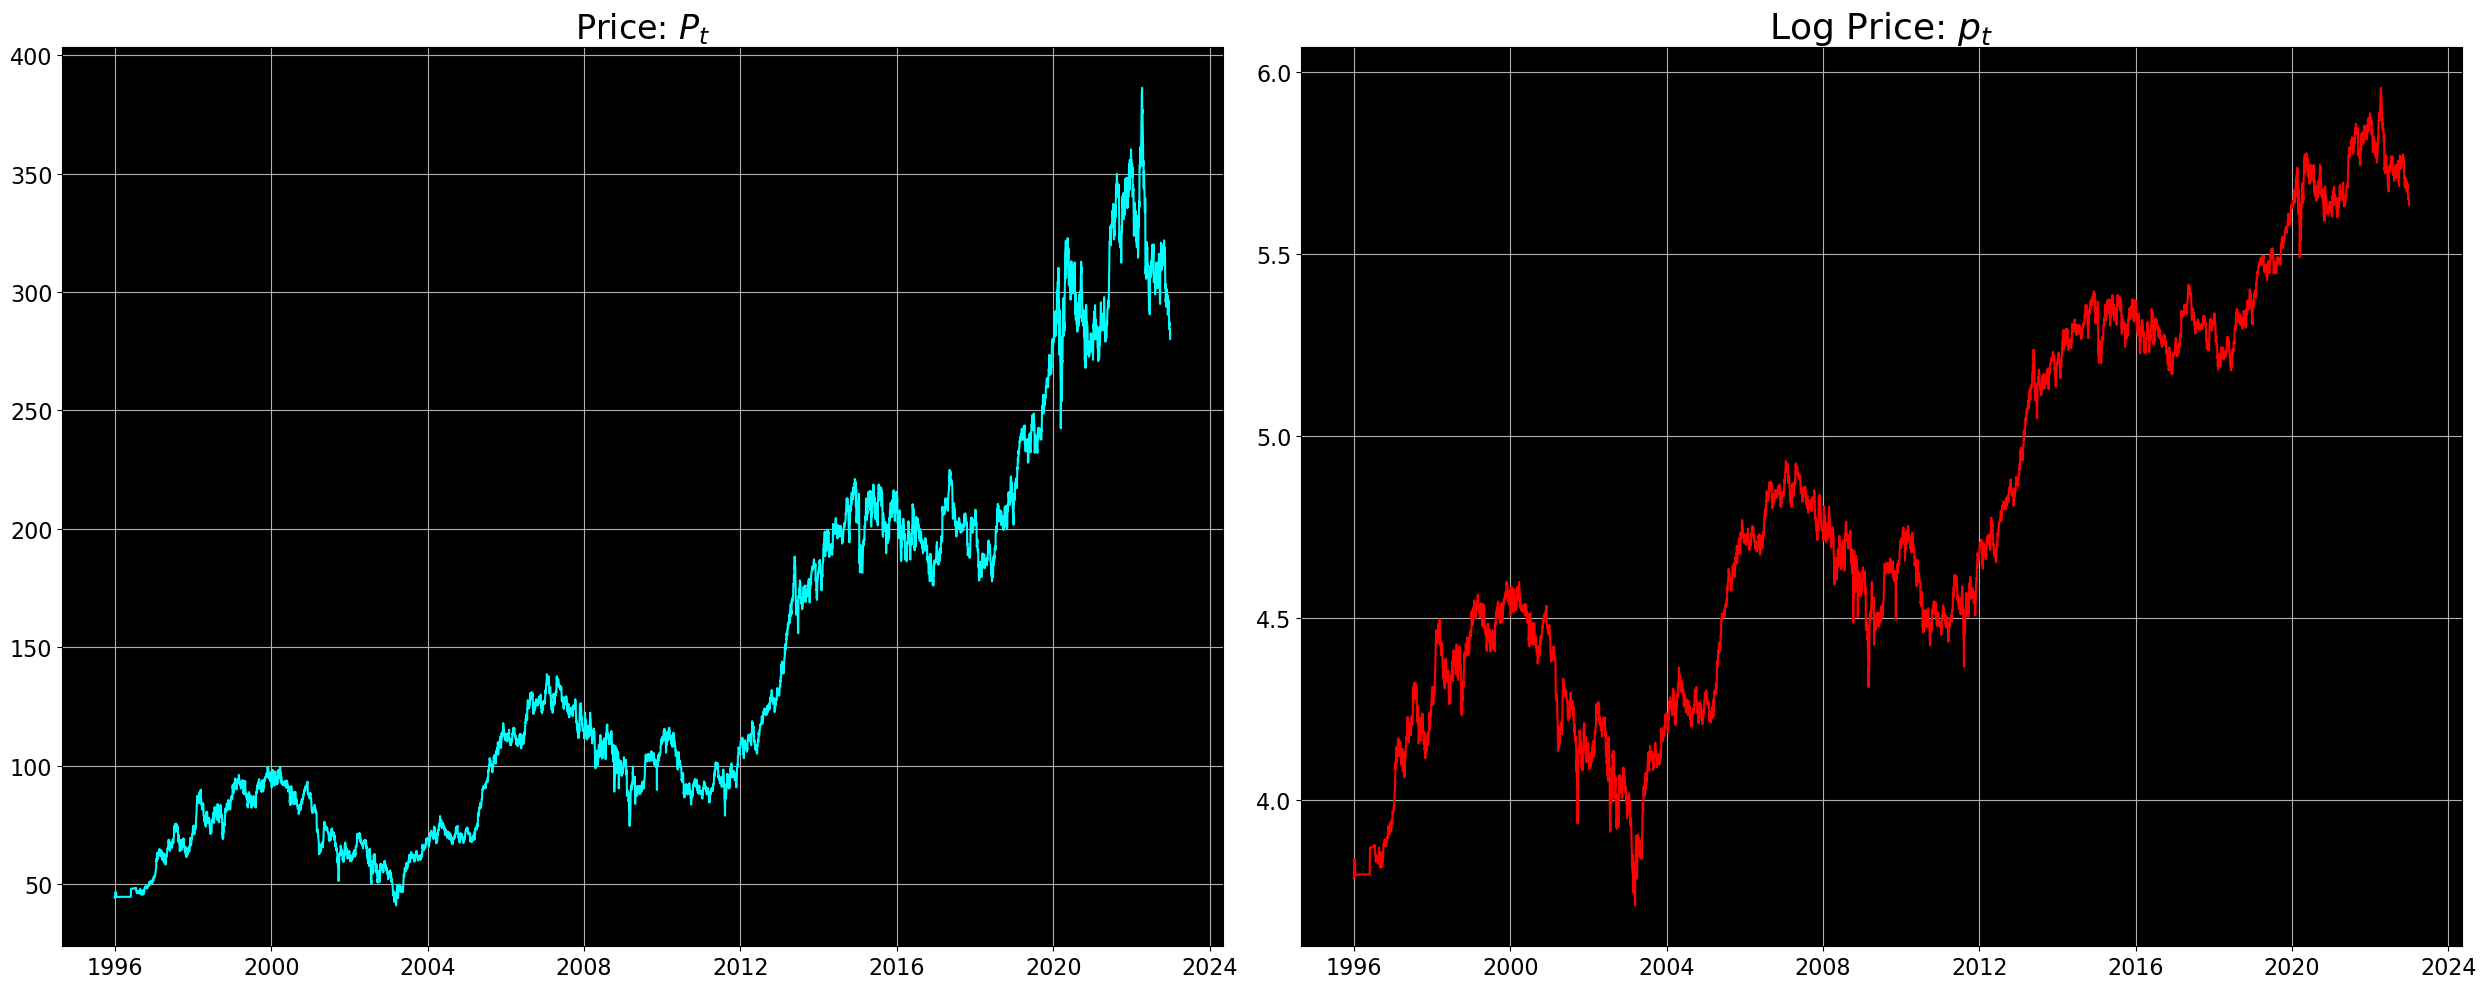

Scatter Plot - Prices


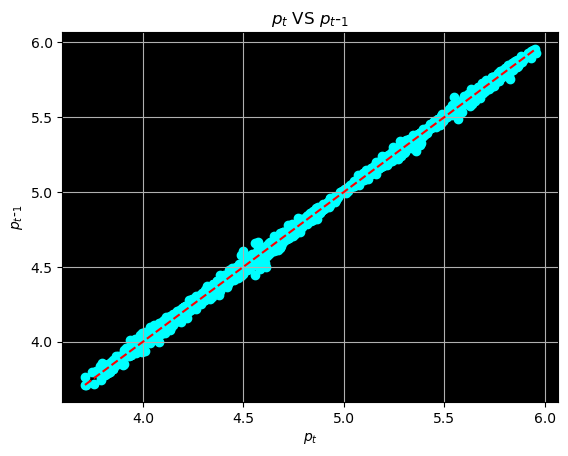

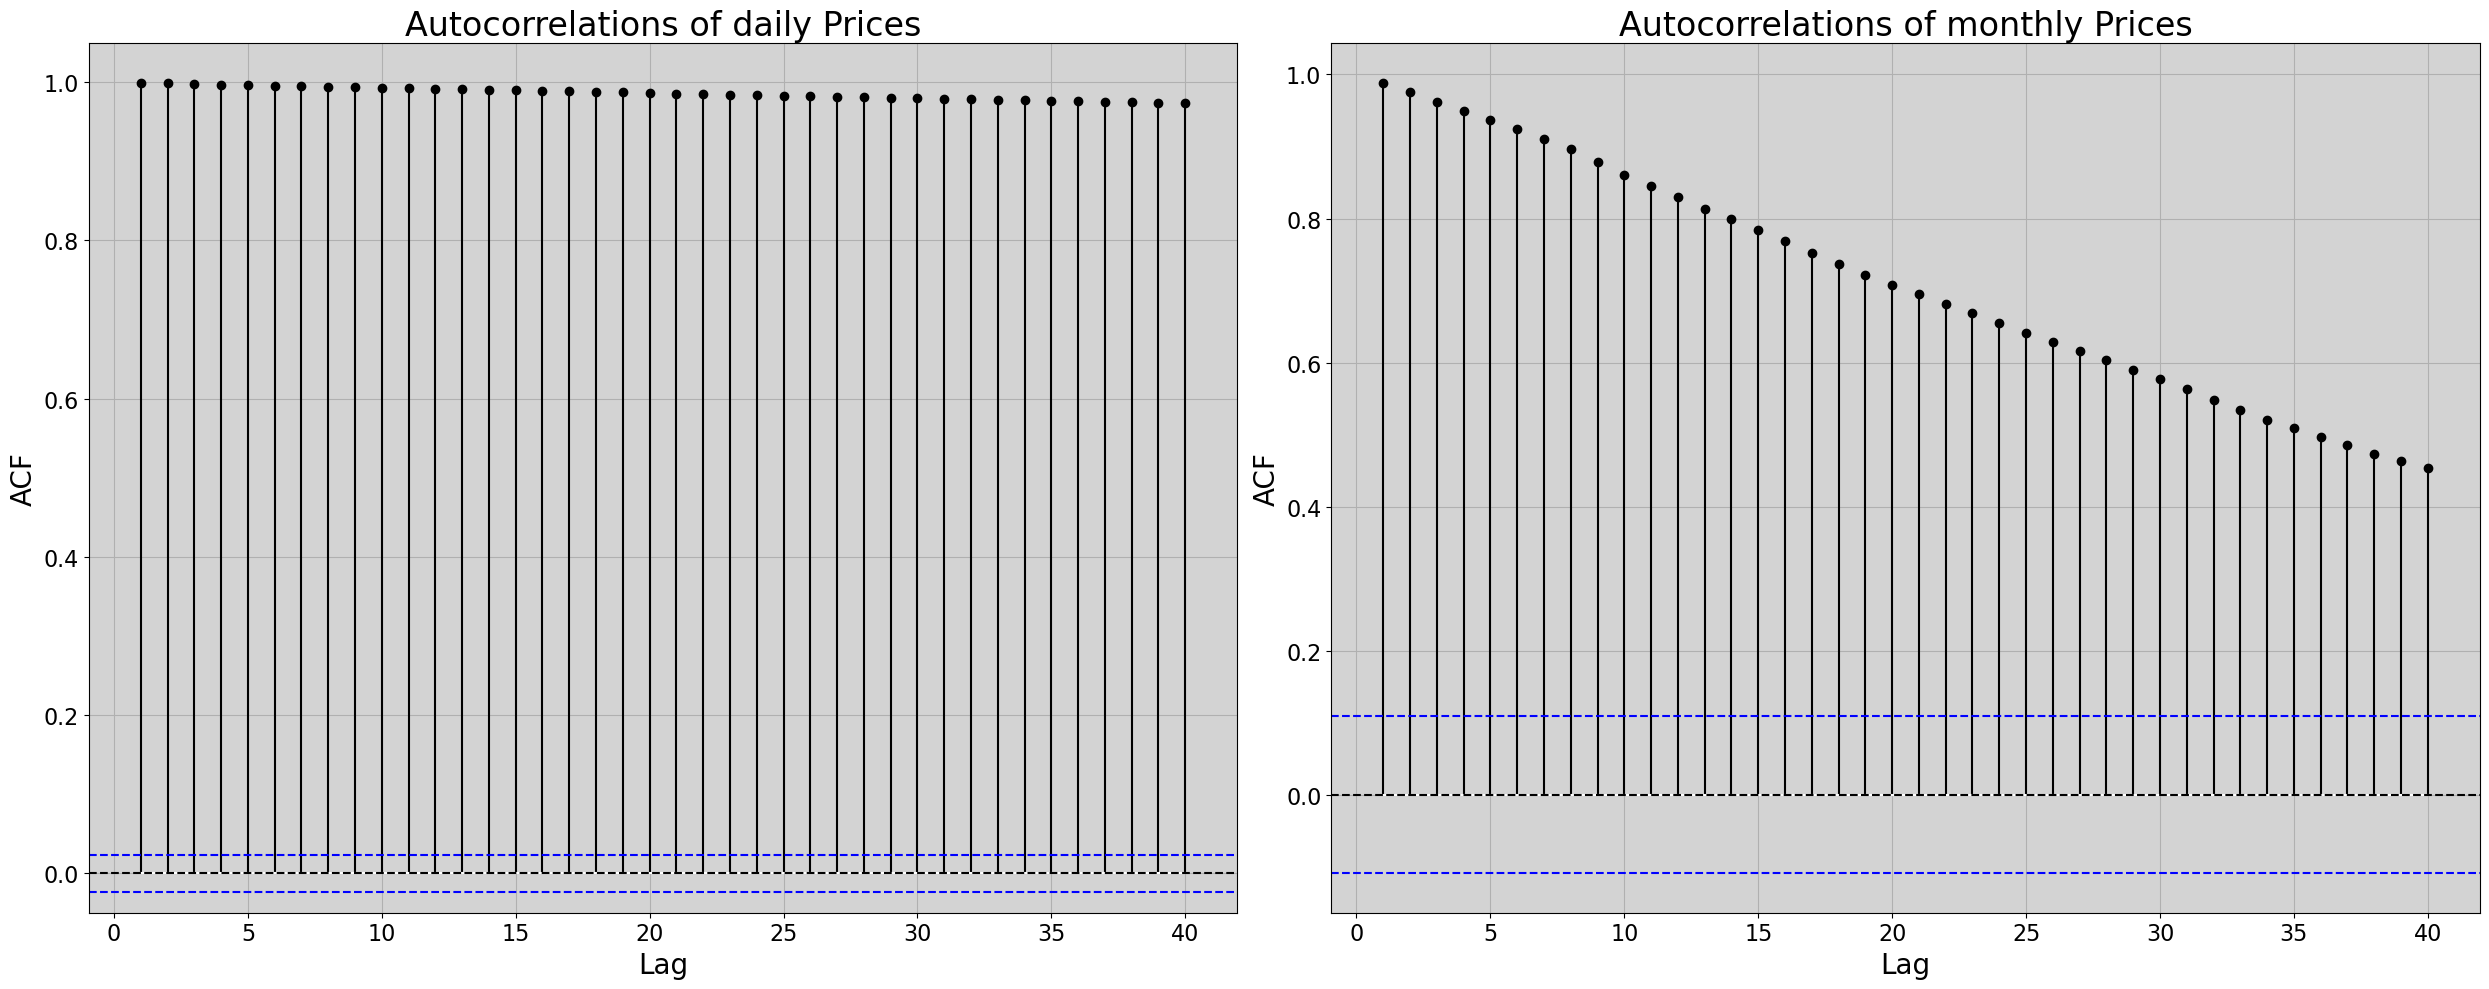

Daily: +/- 0.024
Monthly: +/- 0.109
Time series - Returns


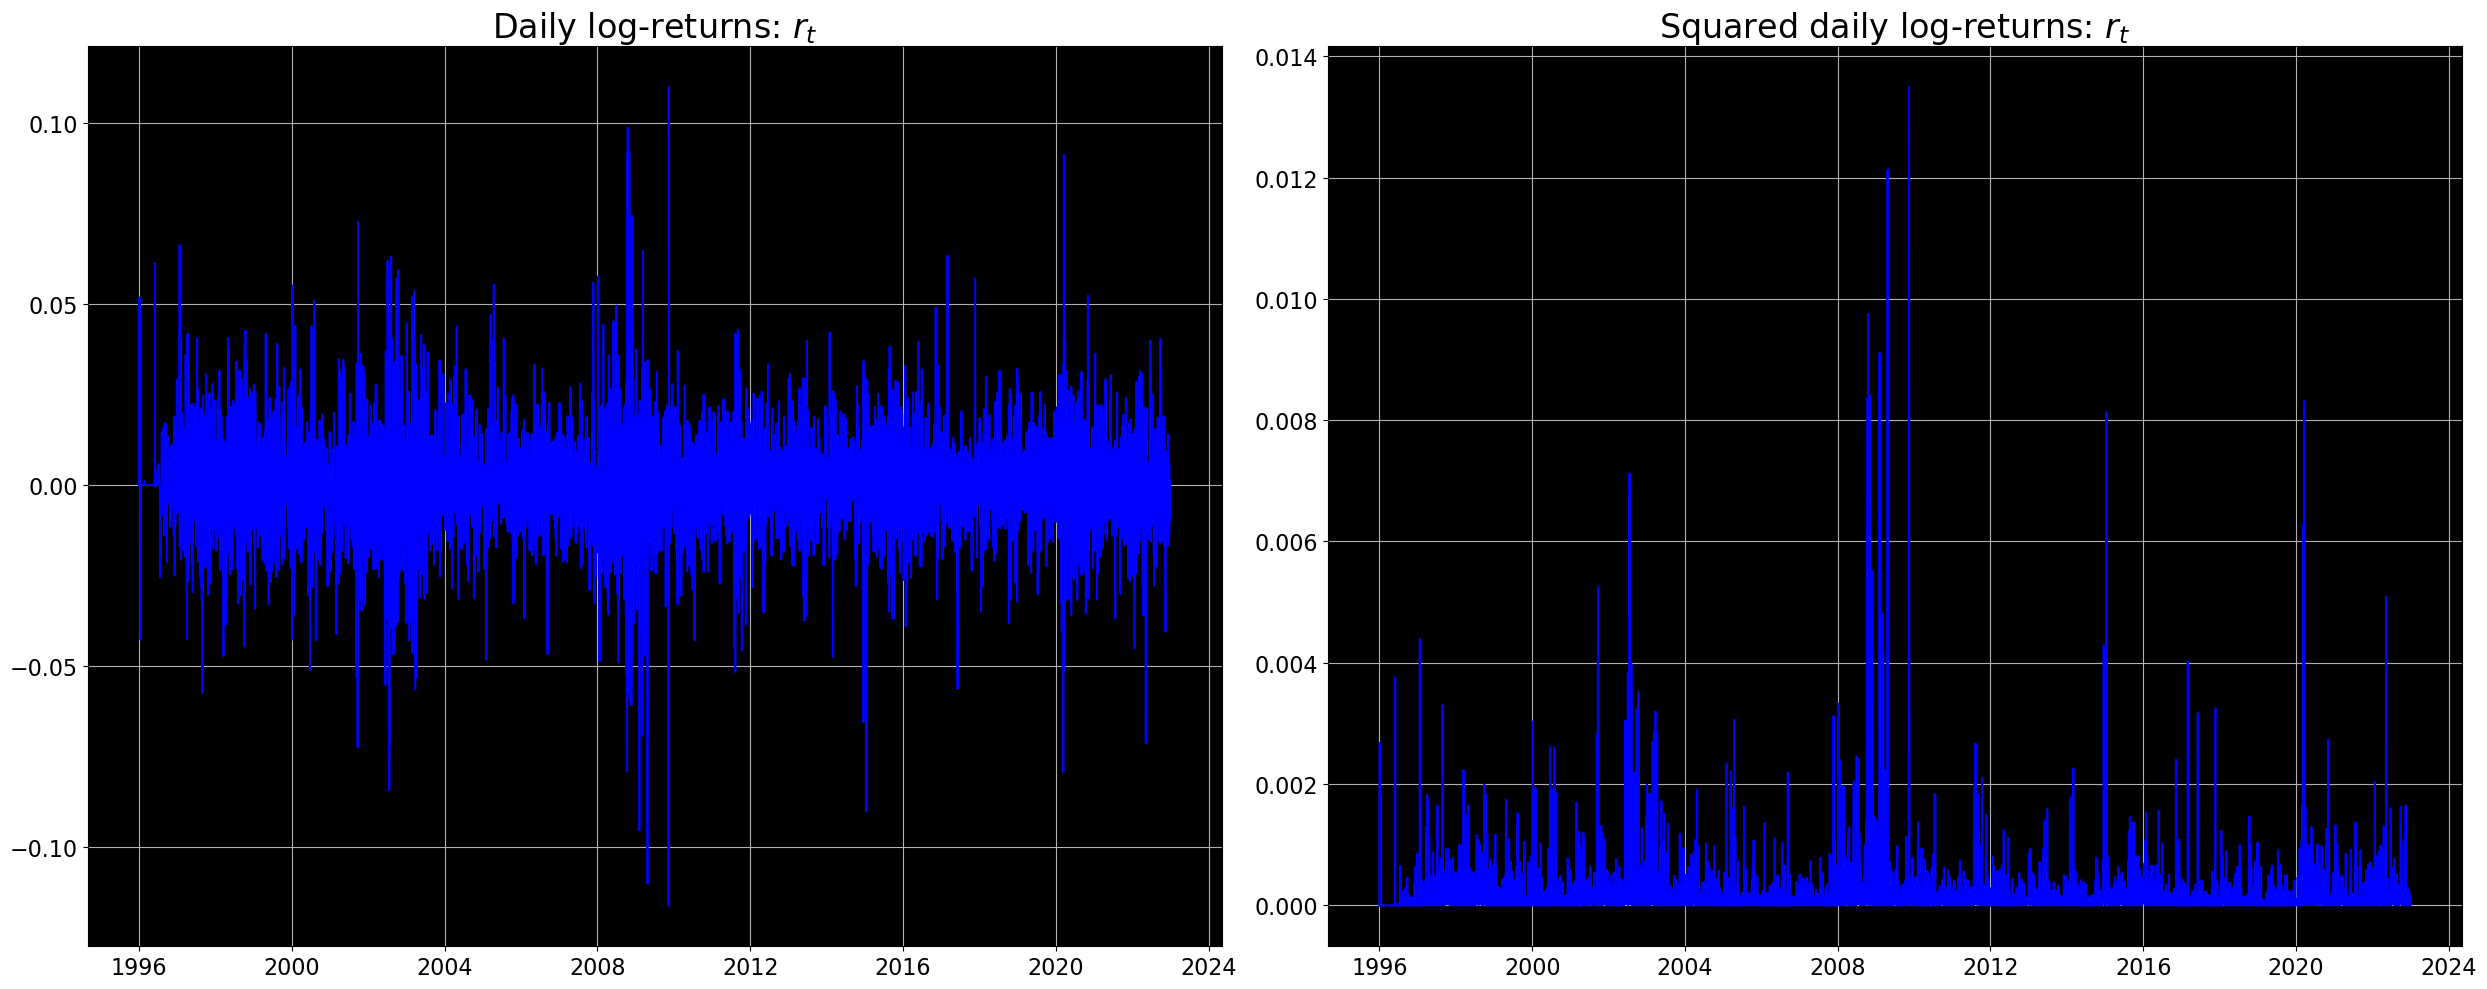

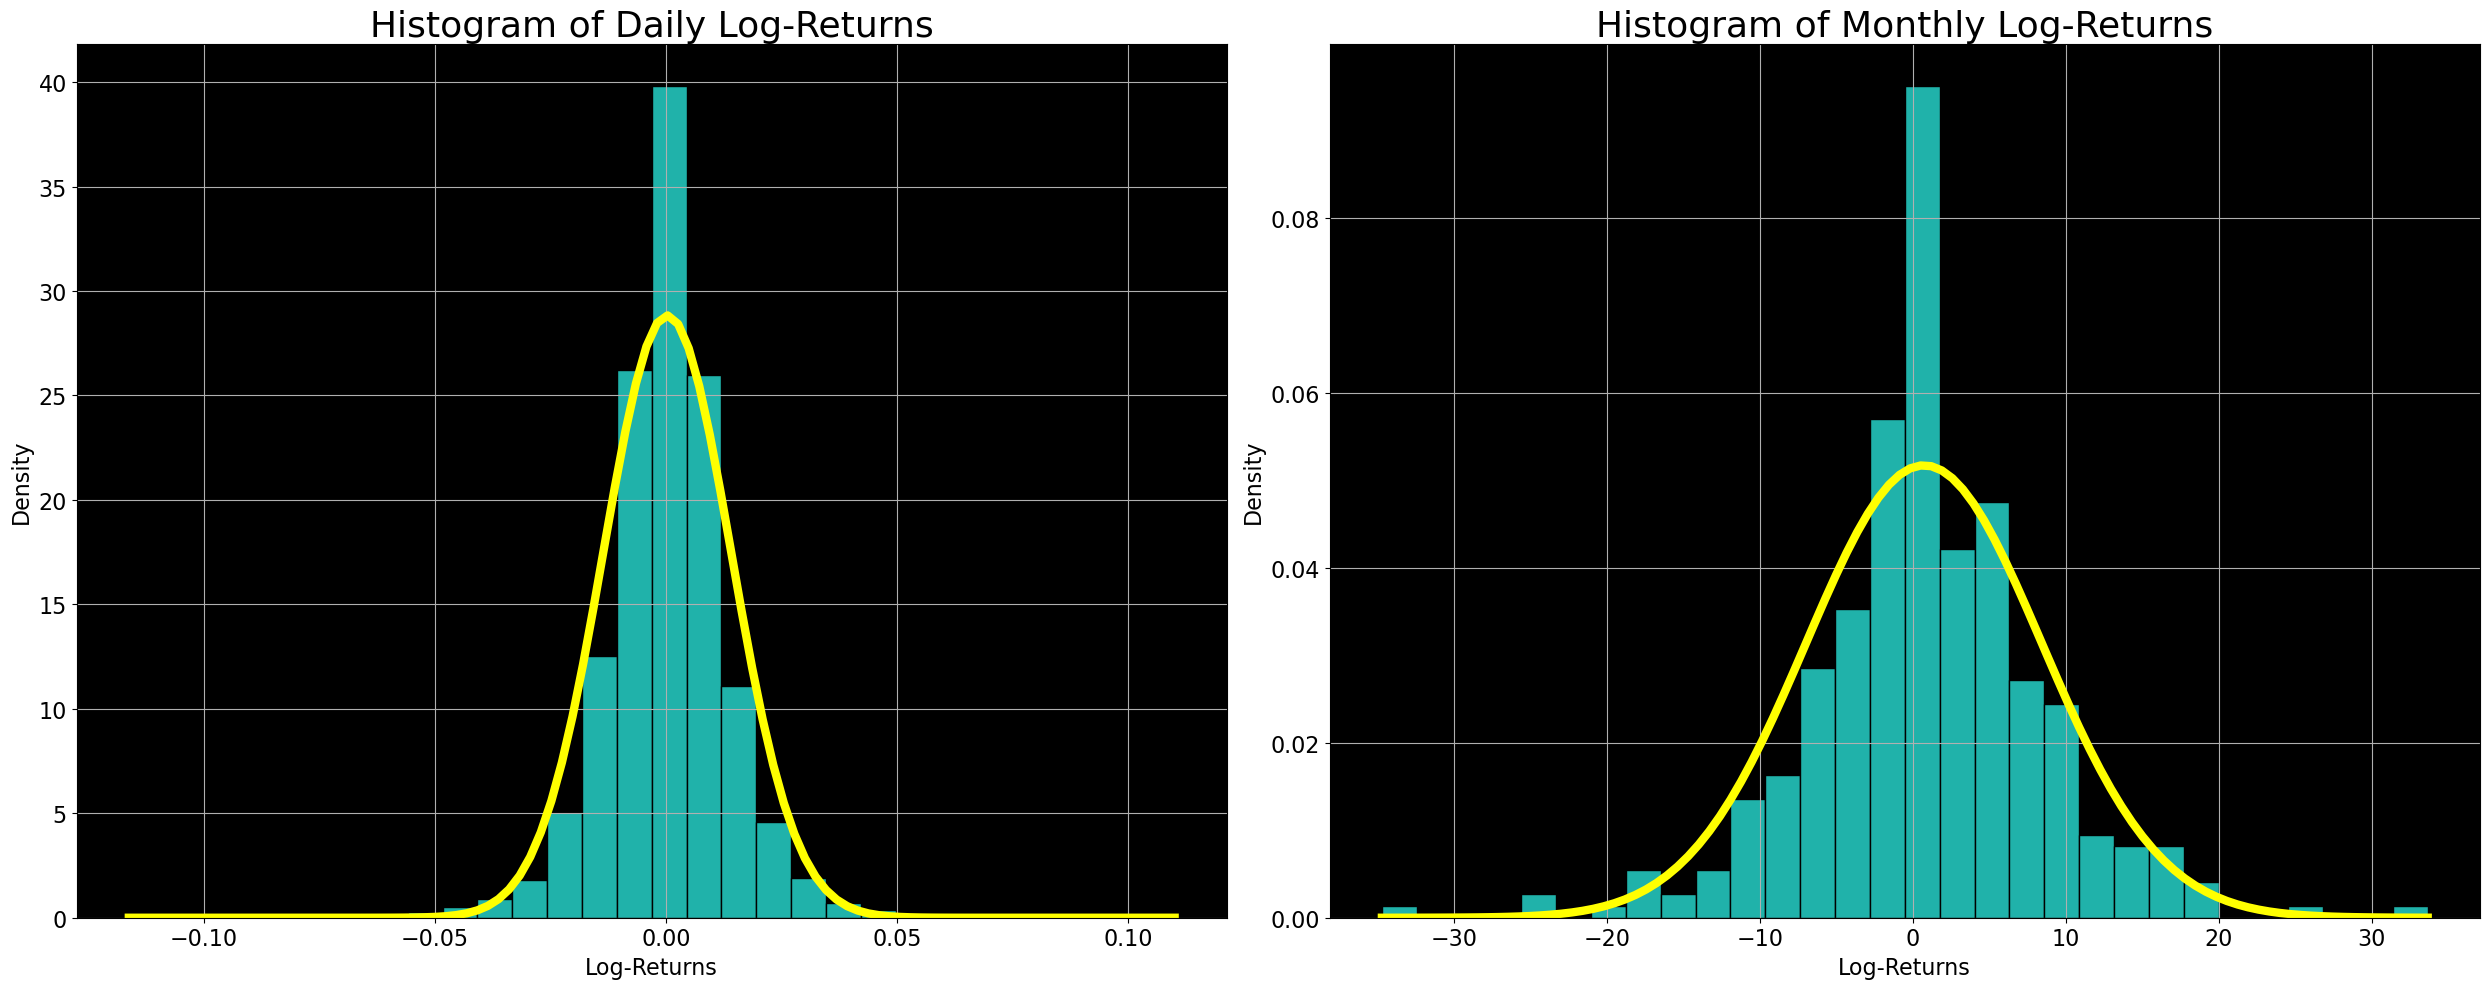

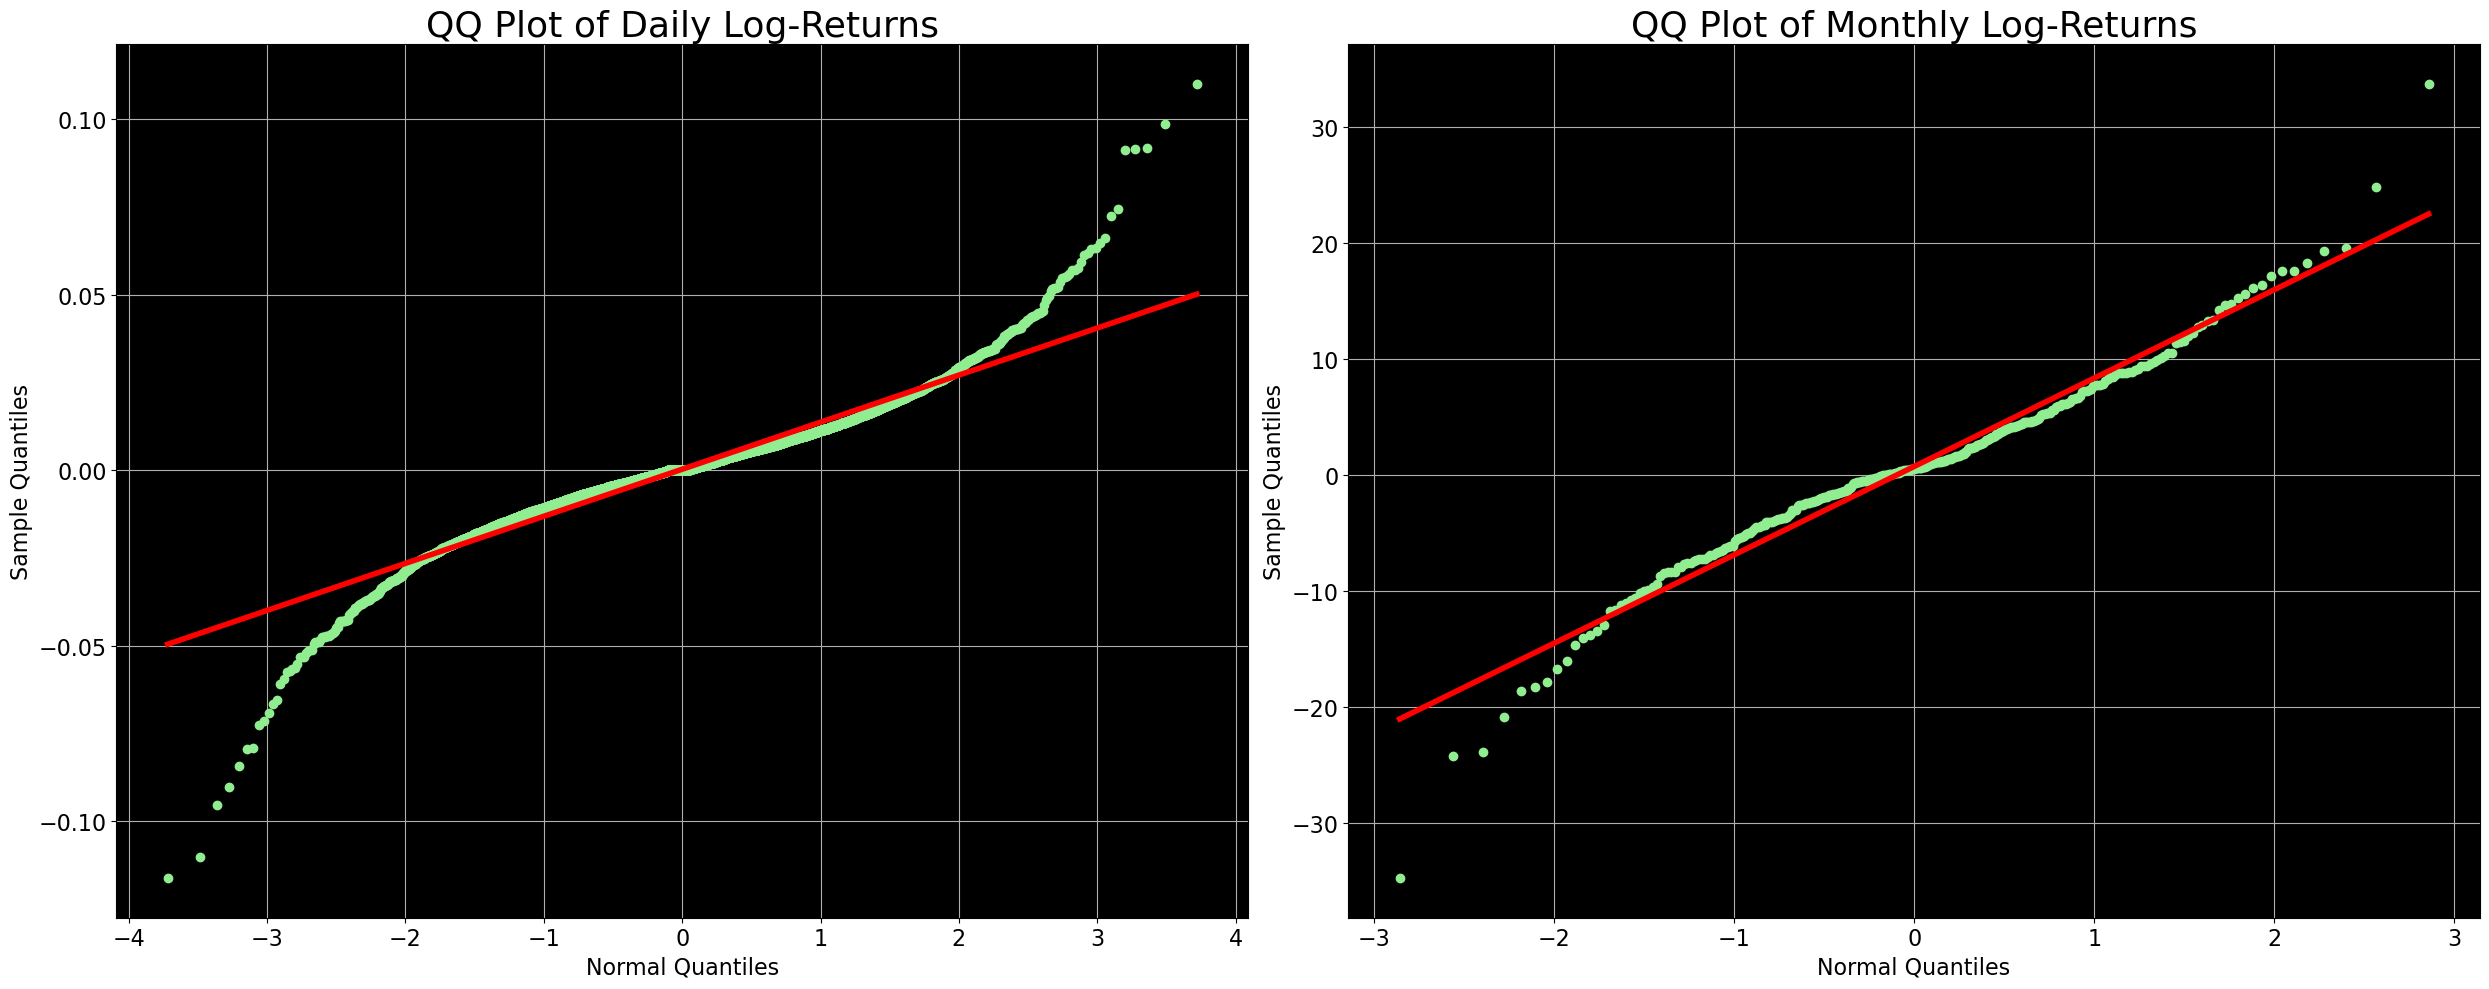

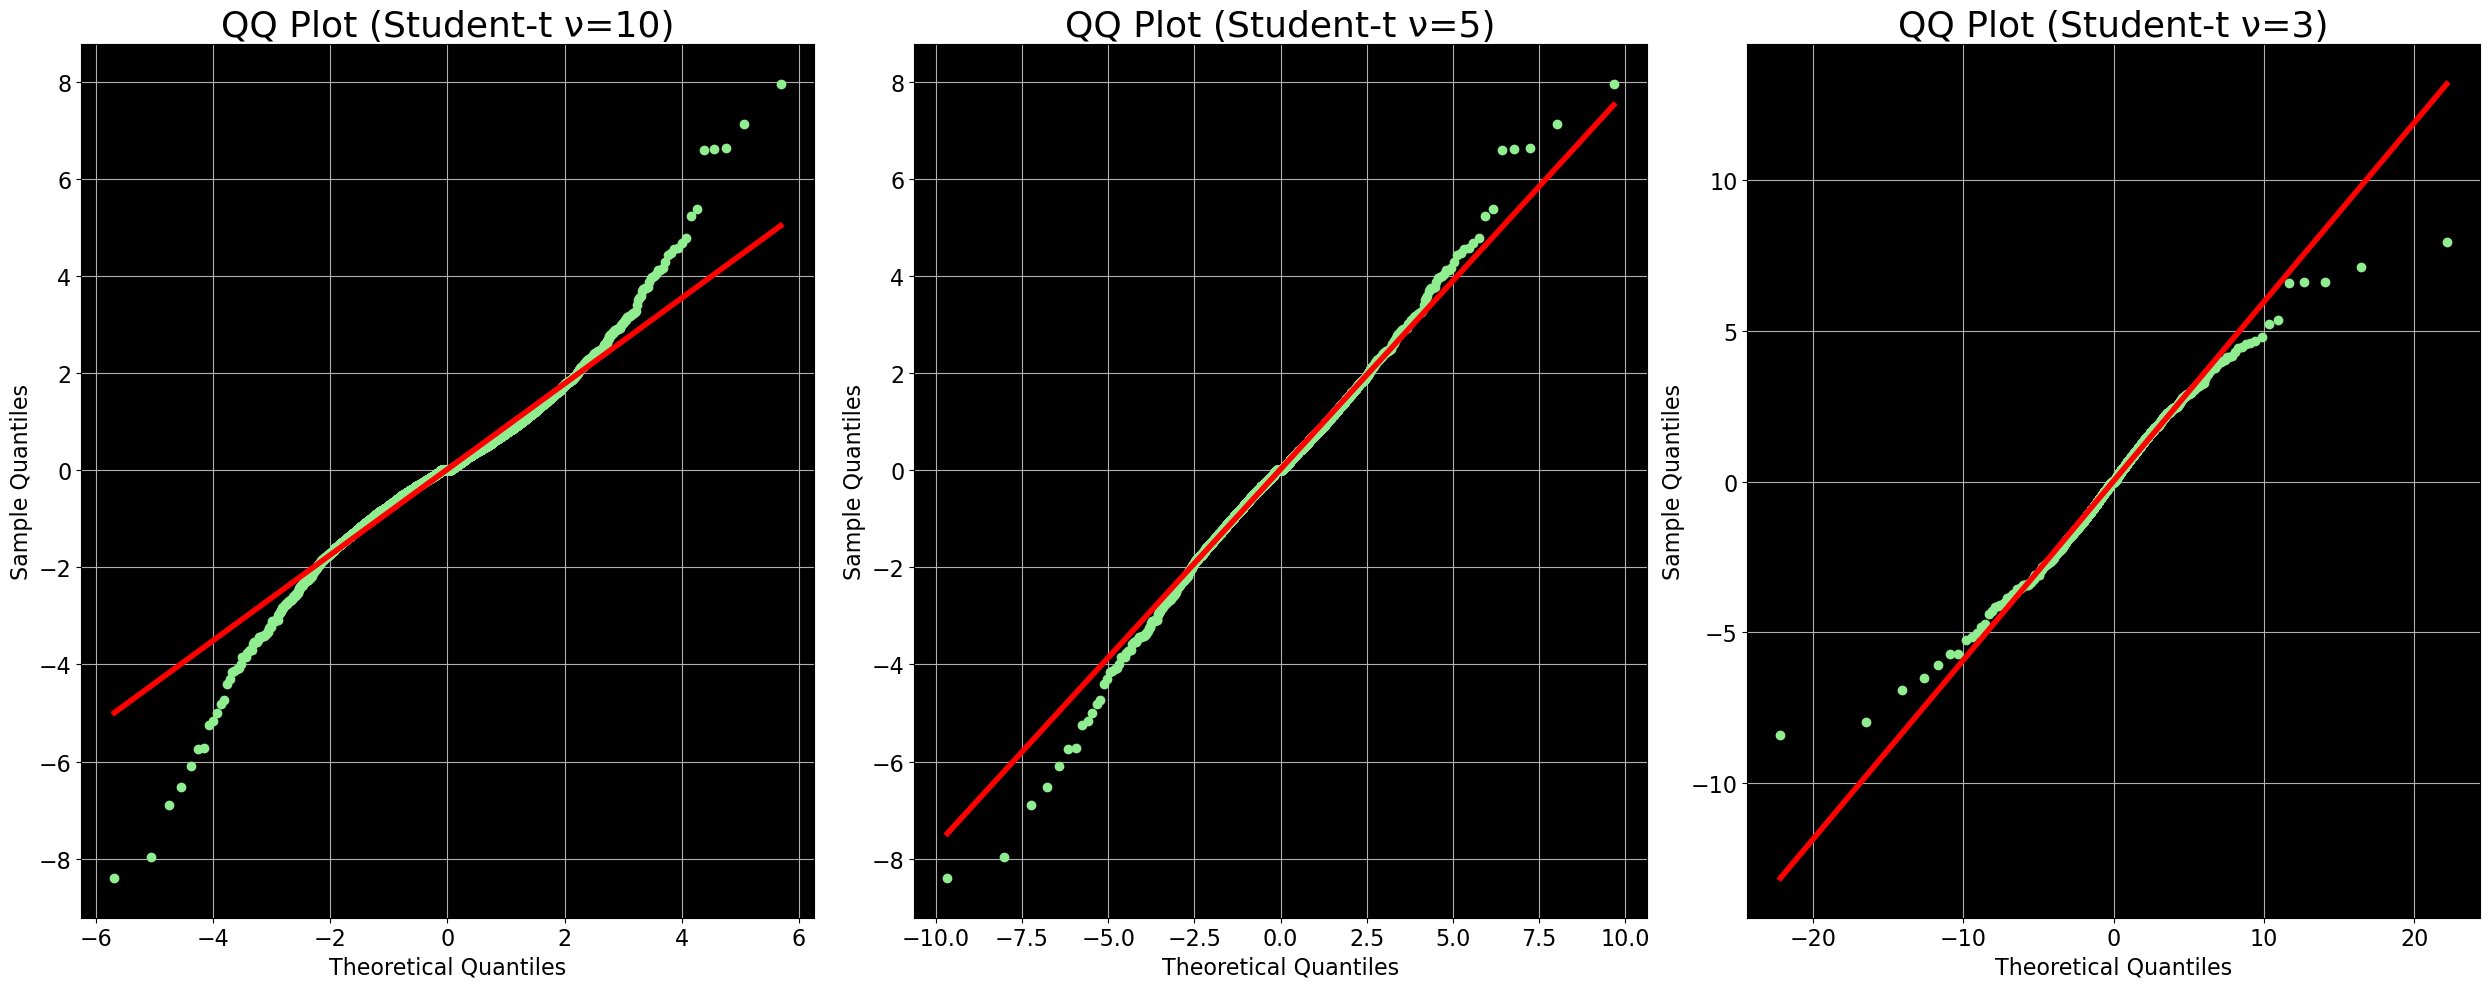

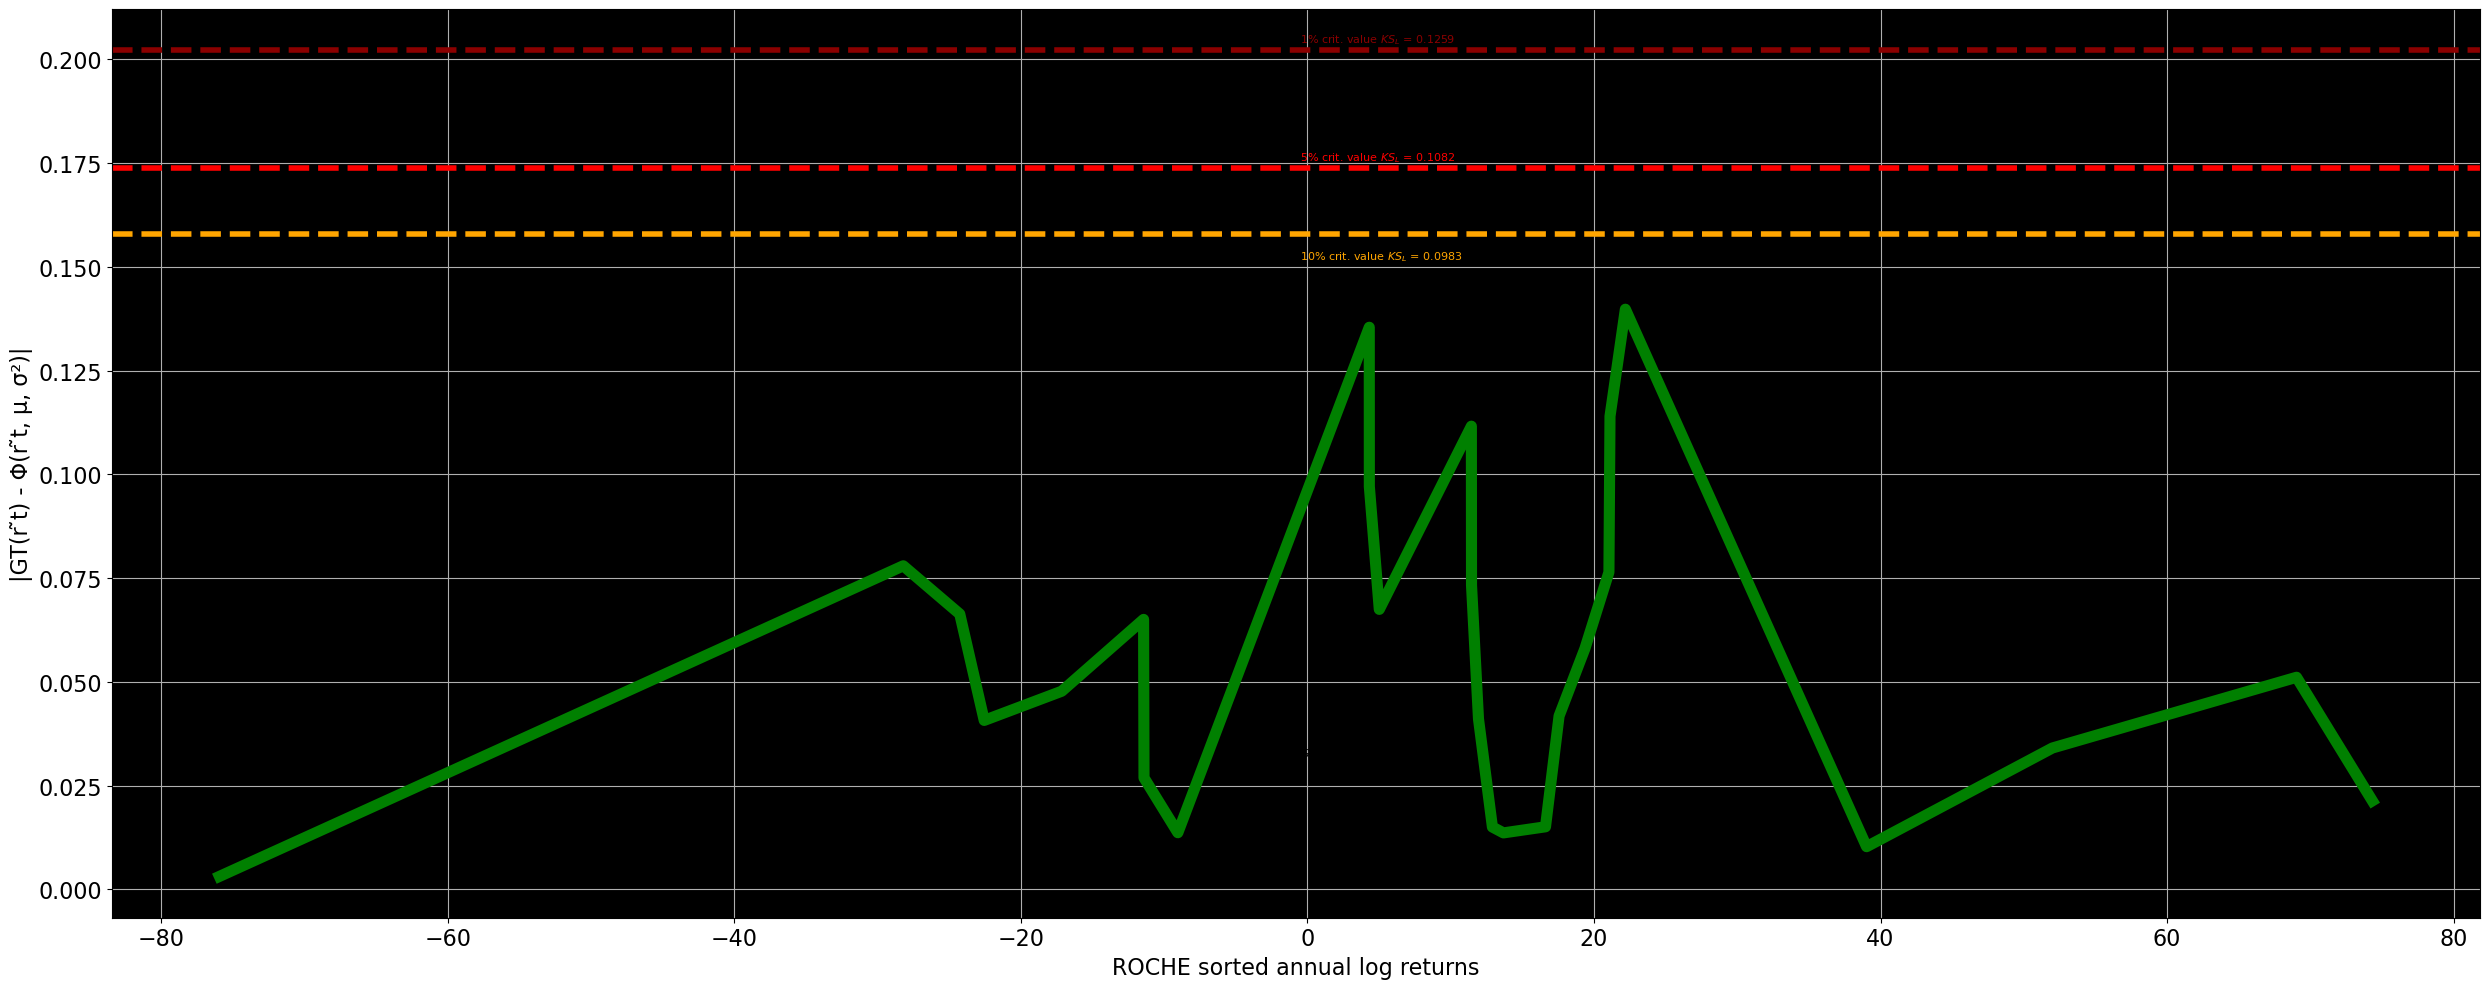

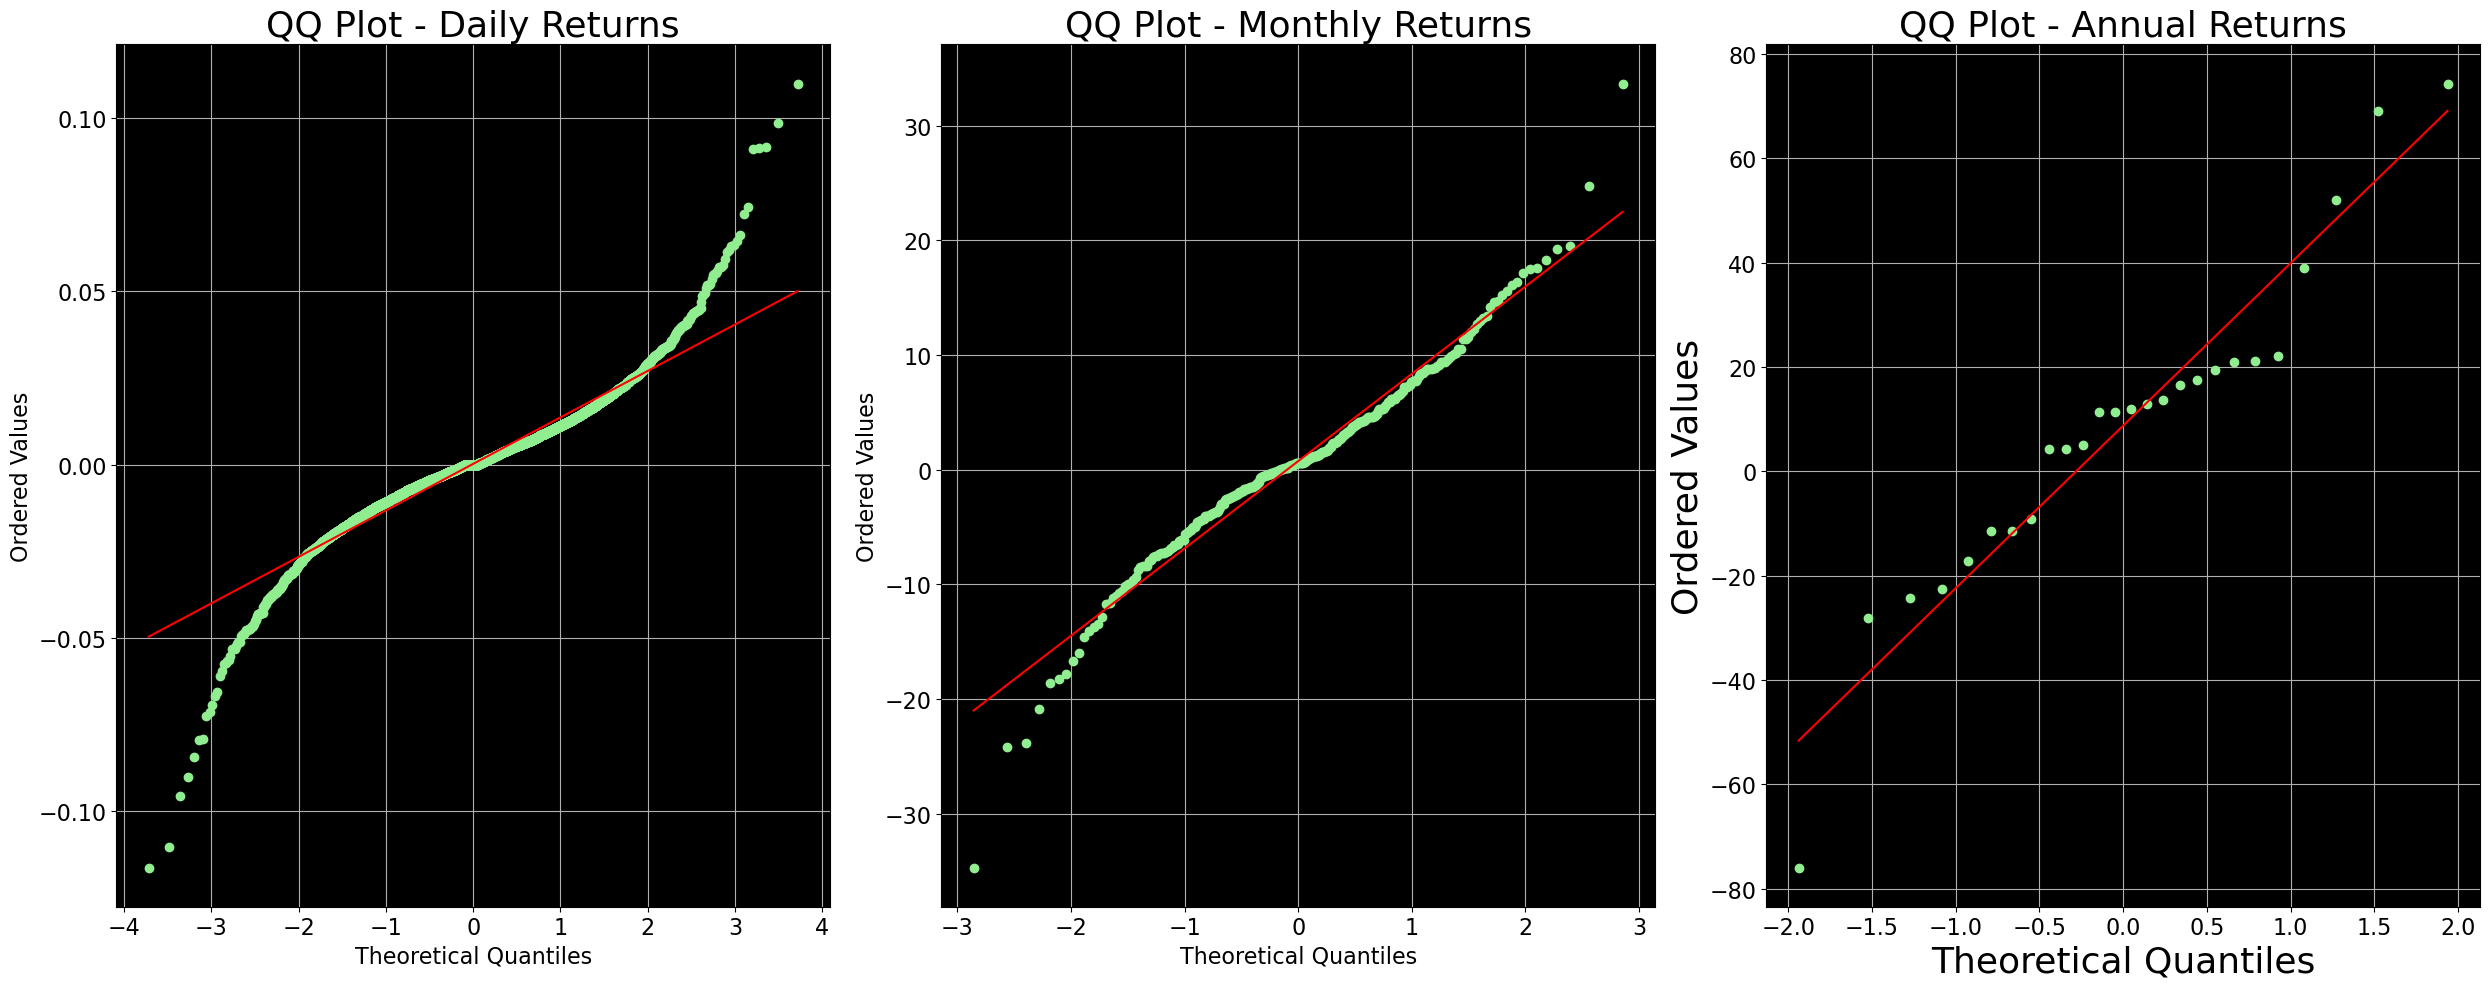

Statistics of Daily / Weekly / Monthly / Annual returns:
                               daily      weekly    monthly    annual
Mean                         0.00027     0.16607    0.73152   8.25304
St.Deviation                 0.01384     4.71513    7.71422  30.87073
Diameter.C.I.Mean            0.00033     0.24638    0.84260  12.10133
Skewness                    -0.11223    -0.30361   -0.17575  -0.15193
Kurtosis                     6.24834     7.09563    2.59197   1.05930
Excess.Kurtosis              3.24834     4.09563   -0.40803  -1.94070
Min                         -0.11617   -31.89023  -34.71115 -75.92847
Quant5                      -0.02076    -6.70581  -11.15908 -27.41396
Quant25                     -0.00647    -1.79964   -3.03437 -11.40215
Median                       0.00000     0.13844    0.55626  11.45557
Quant75                      0.00717     2.25422    4.69201  19.37421
Quant95                      0.02137     6.93450   13.22125  65.62740
Max                          0.10

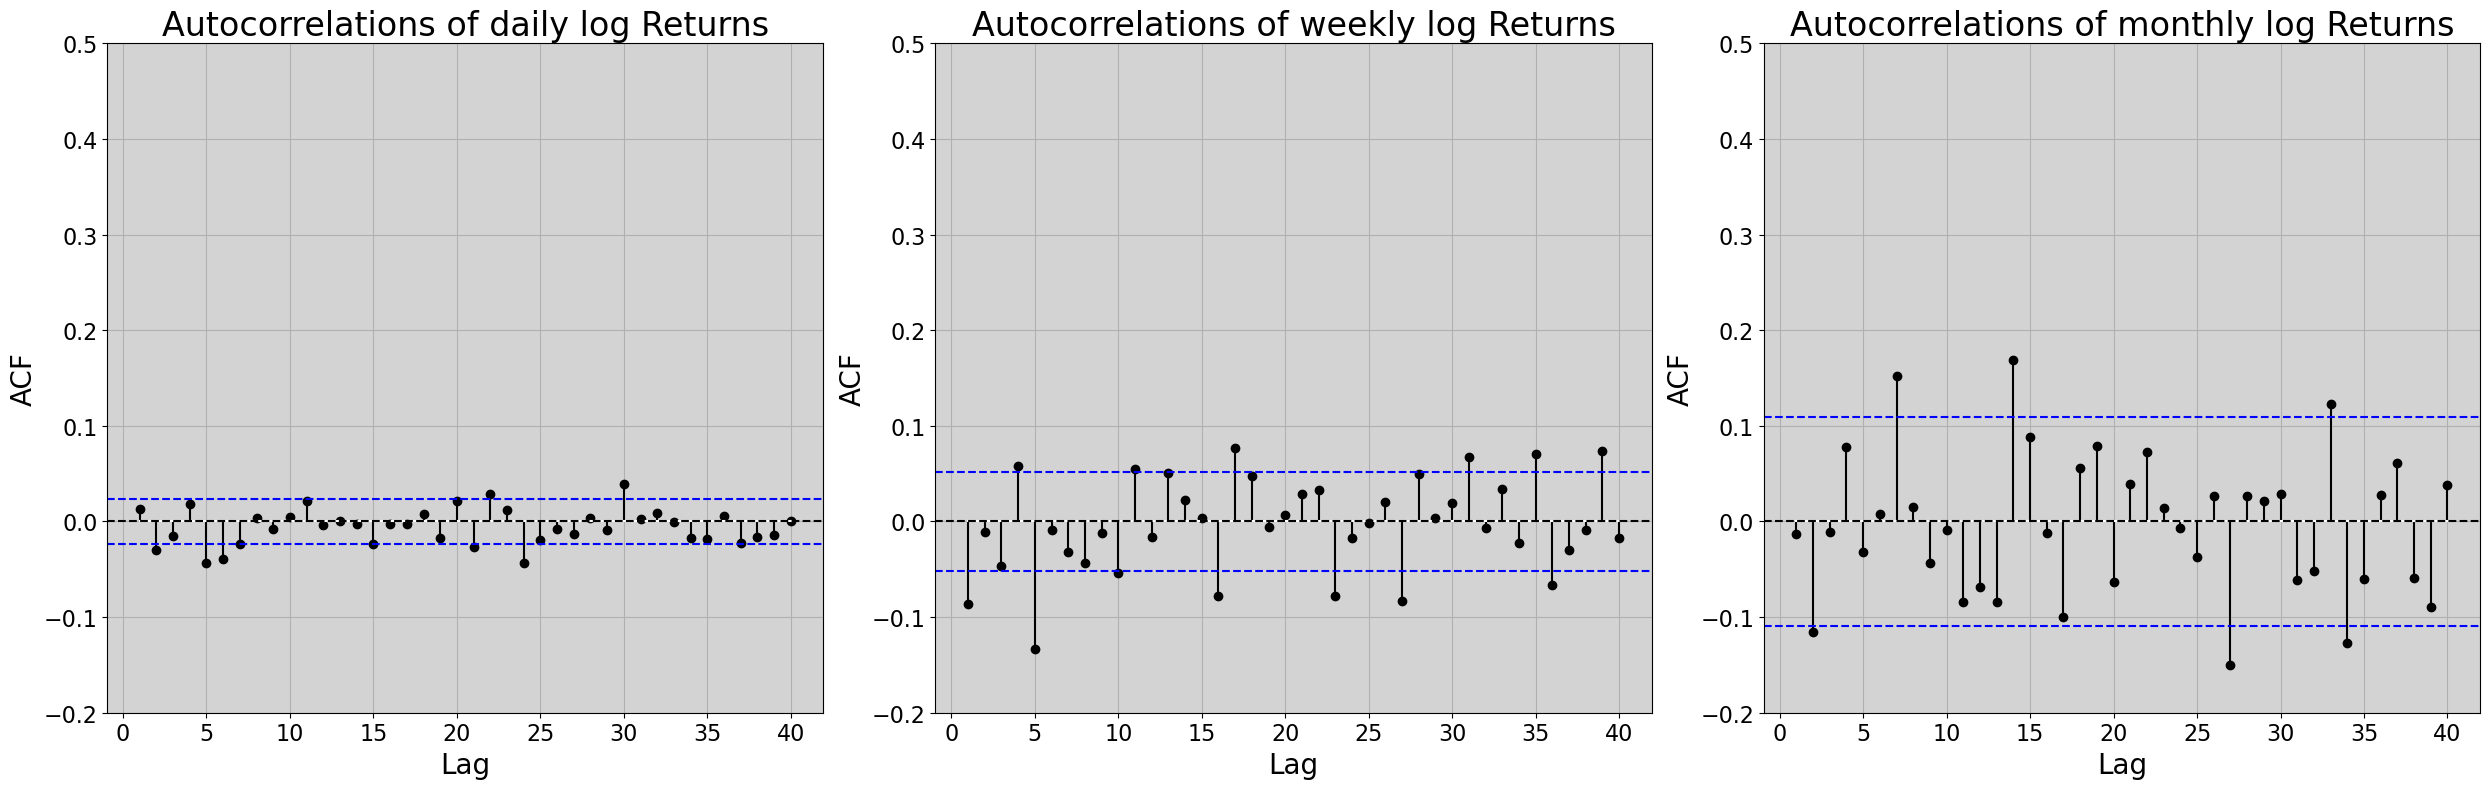

Daily: +/- 0.024
Weekly: +/- 0.052
Monthly: +/- 0.109

Daily returns: values of ACF, Box-pierce and Ljung Box statistics: first 25 lags
     lag    acf  acf diam.  acf test  B-P stat  B-P pval  L-B stat  L-B pval  \
0    1.0  0.013      0.024     1.076     1.158     0.282     1.159     0.282   
1    2.0 -0.029      0.024    -2.441     7.118     0.028     7.122     0.028   
2    3.0 -0.016      0.024    -1.292     8.789     0.032     8.794     0.032   
3    4.0  0.018      0.024     1.522    11.105     0.025    11.112     0.025   
4    5.0 -0.043      0.024    -3.565    23.814     0.000    23.834     0.000   
5    6.0 -0.039      0.024    -3.268    34.492     0.000    34.524     0.000   
6    7.0 -0.024      0.024    -1.952    38.303     0.000    38.341     0.000   
7    8.0  0.004      0.024     0.304    38.396     0.000    38.433     0.000   
8    9.0 -0.008      0.024    -0.686    38.866     0.000    38.905     0.000   
9   10.0  0.004      0.024     0.355    38.992     0.000    39.0

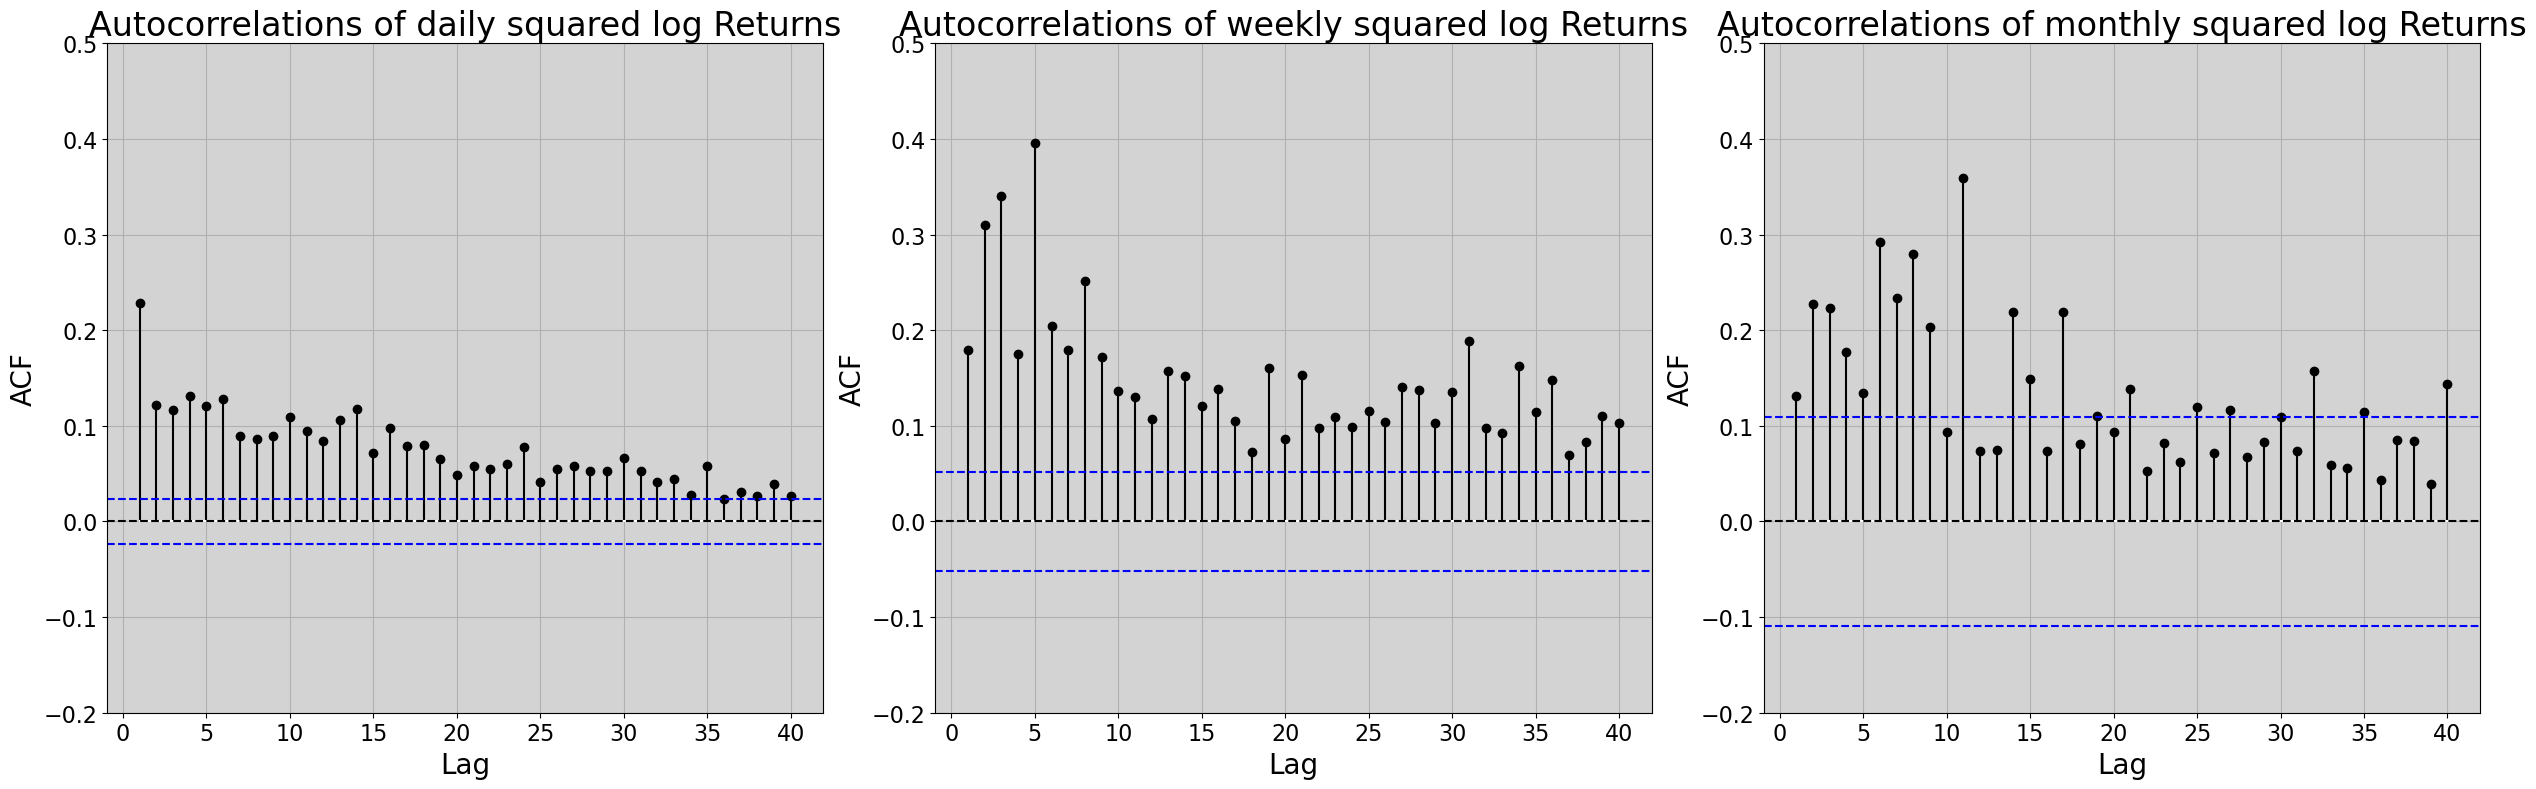

Daily: +/- 0.024
Weekly: +/- 0.052
Monthly: +/- 0.109


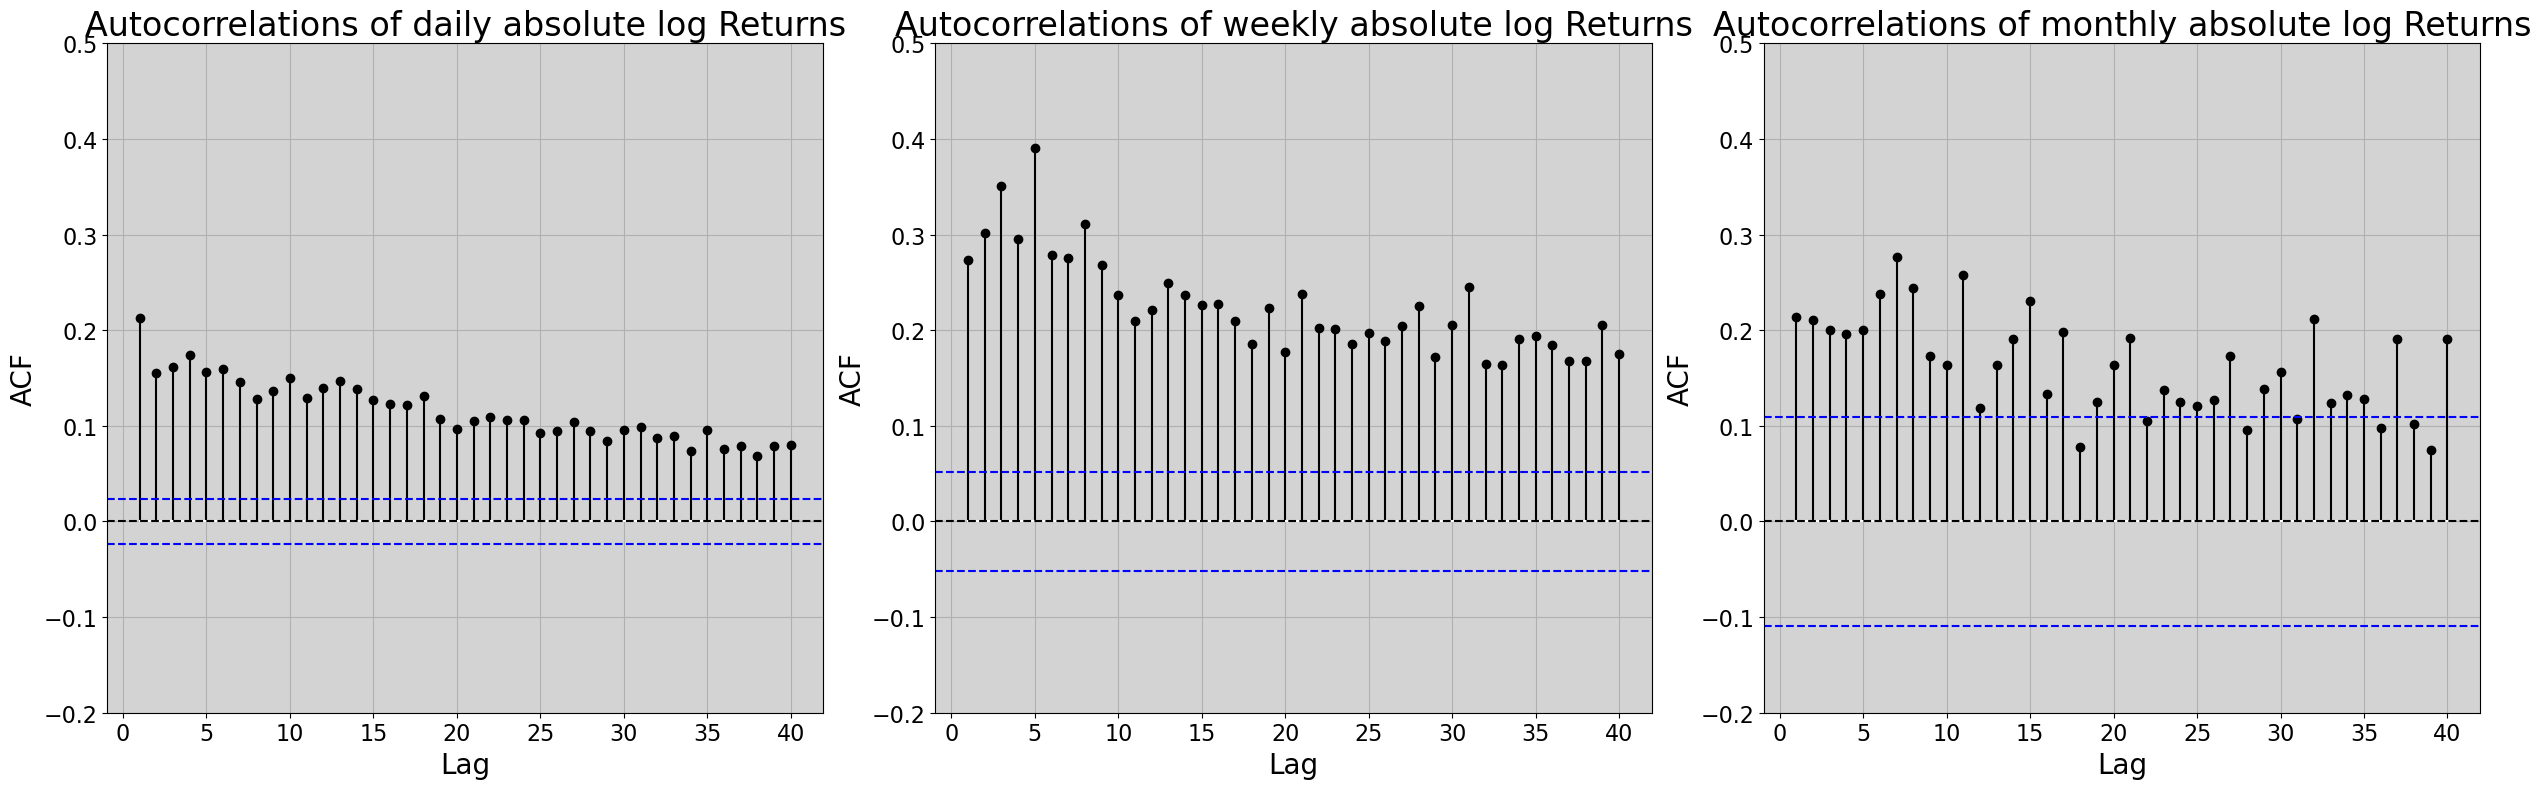

Daily: +/- 0.024
Weekly: +/- 0.052
Monthly: +/- 0.109

Daily squared returns: values of ACF, Box-pierce and Ljung Box statistics: first 25 lags
     lag    acf  acf diam.  acf test  B-P stat  B-P pval  L-B stat  L-B pval  \
0    1.0  0.229      0.024    18.994   360.756       0.0   360.913       0.0   
1    2.0  0.122      0.024    10.118   463.131       0.0   463.347       0.0   
2    3.0  0.116      0.024     9.644   556.140       0.0   556.424       0.0   
3    4.0  0.132      0.024    10.936   675.730       0.0   676.118       0.0   
4    5.0  0.120      0.024    10.001   775.759       0.0   776.249       0.0   
5    6.0  0.128      0.024    10.651   889.197       0.0   889.819       0.0   
6    7.0  0.089      0.024     7.406   944.044       0.0   944.737       0.0   
7    8.0  0.086      0.024     7.125   994.808       0.0   995.575       0.0   
8    9.0  0.090      0.024     7.463  1050.510       0.0  1051.366       0.0   
9   10.0  0.109      0.024     9.082  1133.000       0.0

C:\Users\g\AppData\Local\Temp\ipykernel_24184\4107909062.py:23: RuntimeWarning: divide by zero encountered in divide
  sd_plot_ub = roll_mom_manual[:,1]+1.96*(1/(2*sd_plot)*np.sqrt(mu4-sd_plot**4))/np.sqrt(window_length)
C:\Users\g\AppData\Local\Temp\ipykernel_24184\4107909062.py:23: RuntimeWarning: invalid value encountered in multiply
  sd_plot_ub = roll_mom_manual[:,1]+1.96*(1/(2*sd_plot)*np.sqrt(mu4-sd_plot**4))/np.sqrt(window_length)
C:\Users\g\AppData\Local\Temp\ipykernel_24184\4107909062.py:24: RuntimeWarning: divide by zero encountered in divide
  sd_plot_lb = roll_mom_manual[:,1]-1.96*(1/(2*sd_plot)*np.sqrt(mu4-sd_plot**4))/np.sqrt(window_length)
C:\Users\g\AppData\Local\Temp\ipykernel_24184\4107909062.py:24: RuntimeWarning: invalid value encountered in multiply
  sd_plot_lb = roll_mom_manual[:,1]-1.96*(1/(2*sd_plot)*np.sqrt(mu4-sd_plot**4))/np.sqrt(window_length)


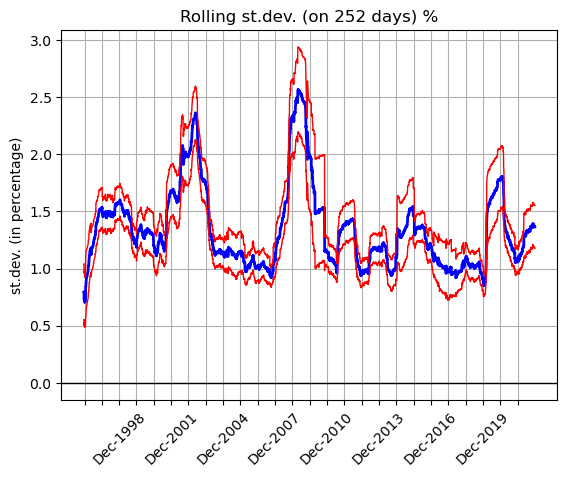

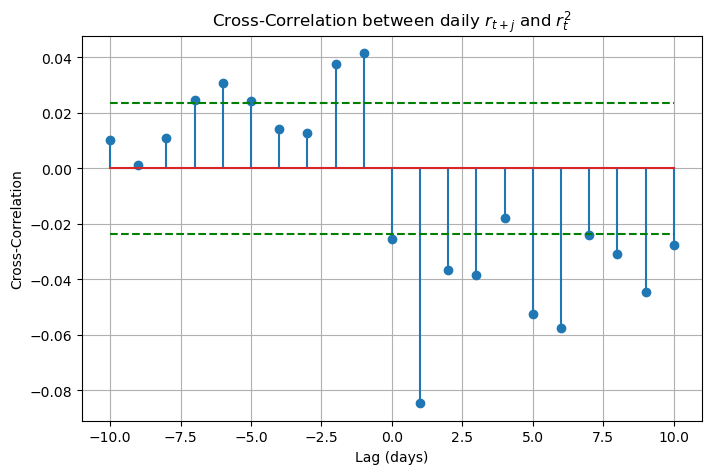

In [74]:
def main():
    #STYLIZED FACT 1
    print("Time series - Prices")
    timeseries_prices(Pt_d, pt_d)
    print("Scatter Plot - Prices")
    scatter_prices(pt_d,'$p_t$','$p_t$-$_1$','$p_t$ VS $p_t$-$_1$') 
    autocorr_prices(pt_d, pt_m)
    
    #STYLIZED FACT 2
    print("Time series - Returns")
    timeseries_ret(rt_d)
    
    #STYLIZED FACT 3
    histogram (rt_d,rt_m)
    #STYLIZED FACT 4
    QQ_plot(rt_d,rt_m)
    QQ_plot_heavytails(rt_d)
    #STYLIZED FACT 5
    lilliefors_test (rt_y)
    QQ_plot_vs_Nor (rt_d,rt_m,rt_y)
    
    X = {                         #define dictionary of returns
    'daily': rt_d,
    'weekly': rt_w,
    'monthly': rt_m,
    'annual': rt_y
    }
    
    statistics = {
    key: custom_stats(data.iloc[1:])  # apply to each returns located in four keys of dictionary X
    for key, data in X.items()         
    }
    statistics_df = pd.DataFrame(statistics).round(5)
    statistics_df.to_excel("Statistics_Returns.xlsx")  #export stats to excel
    print("Statistics of Daily / Weekly / Monthly / Annual returns:")
    print(statistics_df)
    
    #STYLIZED FACT 6
    autocorr_ret(rt_d,rt_w,rt_m,40,0)             #parameter passed for log returns
    tests_rt_d = ACF_custom(rt_d, 25)
    tests_rt_m = ACF_custom(rt_m, 25)
    tests_rt_d.to_excel("Daily_returns.xlsx")     #export test stats table to excel
    tests_rt_m.to_excel("Monthly_returns.xlsx")   
    print("\nDaily returns: values of ACF, Box-pierce and Ljung Box statistics: first 25 lags")
    print(tests_rt_d)
    print("\nMonthly returns: values of ACF, Box-pierce and Ljung Box statistics: first 25 lags")
    print(tests_rt_m)
    
    #STYLIZED FACT 7
    autocorr_ret(rt_d,rt_w,rt_m,40,1)     #parameter passed for squared returns
    autocorr_ret(rt_d,rt_w,rt_m,40,2)     #parameter passed for absolute returns
    rt_d2 = rt_d**2                       #squared daily log returns
    rt_d_abs = abs(rt_d)                  #absolute daily log returns
    tests_rt_d2 = ACF_custom(rt_d2, 25)
    tests_rt_dAbs = ACF_custom(rt_d_abs, 25)
    tests_rt_d2.to_excel("Daily_Squared_Returns.xlsx")     #export test stats table to excel
    tests_rt_dAbs.to_excel("Daily_Absolute_Returns.xlsx") 
    print("\nDaily squared returns: values of ACF, Box-pierce and Ljung Box statistics: first 25 lags")
    print(tests_rt_d2)
    print("\nDaily absolute returns: values of ACF, Box-pierce and Ljung Box statistics: first 25 lags")
    print(tests_rt_dAbs)
    rt_m2 = rt_m**2                       #squared monthly log returns
    rt_m_abs = abs(rt_m)                  #absolute monthly log returns
    tests_rt_m2 = ACF_custom(rt_m2, 25)
    tests_rt_mAbs = ACF_custom(rt_m_abs, 25)
    tests_rt_m2.to_excel("Monthly_Squared_Returns.xlsx")   
    tests_rt_mAbs.to_excel("Monthly_Absolute_Returns.xlsx") 
    print("\nMonthly squared returns: values of ACF, Box-pierce and Ljung Box statistics: first 25 lags")
    print(tests_rt_m2)
    print("\nMonthly absolute returns: values of ACF, Box-pierce and Ljung Box statistics: first 25 lags")
    print(tests_rt_mAbs)
    rt_y2 = rt_y**2                       #squared yearly log returns
    rt_y_abs = abs(rt_y)                  #absolute yearly log returns
    tests_rt_y2 = ACF_custom(rt_y2, 25)
    tests_rt_yAbs = ACF_custom(rt_y_abs, 25)
    tests_rt_y2.to_excel("Yearly_Squared_Returns.xlsx")   
    tests_rt_yAbs.to_excel("Yearly_Absolute_Returns.xlsx")  
    roll_std(rt_d)                        #plot rolling volatility
    
    #STYLIZED FACT 8
    lag_max = 10
    cross_corr = ccf(rt_d,rt_d2,lag_max=lag_max)
    cross_corr_plot(rt_d,cross_corr,lag_max)
    
main()